# Data cleaning and merging replicate samples 

**Date**: written 2020-05-26, updated 2021-01-28  
**Author**: Katarina Braun 


## Overview
- Clean up the VCFs that the SARSquencer spits out
- Drop any iSNVs not found in both replicates
- Average the frequency of the iSNVs found in these replicates and report this as 'FREQ'
- Drop any iSNVS <3% frequency 
- Make a "TV plot" figure to show comparison of SNVs and indels in replicate 1 and 2 

With the help of Dr. Katia Koelle, we've decided that iSNVs <3% and >97% in this dataset are likely not polymorphic. 

I went back to Grubaugh et al’s 2019 paper that really comprehensively measured the accuracy of PrimalSeq-based amplicon sequencing and showed, I think pretty convincingly, that “PrimalSeq can be used for accurate iSNV detection above 3% when using at least two technical replicates.” I am thinking this is probably the best way to move forward with all of our within-host data — using intersection iSNVs between 3 and 97%.

[Link](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-018-1618-7) to the Grubaugh et al paper discussed above. 

### a note about numbering schemes 

Everything was mapped to the Wuhan reference sequence (MN908947.3).  
Nucleotide numbering scheme should match up with the numbering scheme used in Nextstrain. 

## Input: 

- The VCF files included here have also been modified to discard any variants that fall in ARTIC v3 primer-binding regions and therefore have the file extension `*.vcf.recode.vcf`


- To do this, we filtered the VCFs created by the SARSquencer pipeline using the `filterSNV.sh` script, which identifies primer-binding regions using the `2019-nCoV-tokyo.bed` file. 


- SNV files in VCF format located here: `ncov-WI-within-host/data/vcfs-recode/*`
 
## Output: 

1. Cleaned generated from VCF input files will be located here: `ncov-WI-within-host/data/vcfs-cleaned/*`
     
     
2. Intersection VCFs will be located here: `ncov-WI-within-host/data/vcfs-all/*`


3. TV plot comparing SNV/indel data across technical replicates: `ncov-WI-within-host/figures/intersection-plots/*`

4. Plot comparing iSNV frequency threshold vs linear correlation across replicates: `ncov-WI-within-host/figures/intersection-by-frequency/*`


### import modules and dependencies

In [4]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt
import glob
import os
from matplotlib import pyplot
import matplotlib.pyplot as plt
from pathlib import Path
from os.path import splitext
from functools import reduce
from pandas.api.types import is_numeric_dtype
import warnings
from pandas.core.common import SettingWithCopyWarning
from matplotlib.font_manager import FontProperties 
from matplotlib import cm
import itertools
from matplotlib import container
from matplotlib import gridspec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
import matplotlib as mpl
from pandas.plotting import table
import seaborn as sns
from scipy import stats


from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

## data cleaning

### define functions for data cleaning

In [5]:
# load all text files in a directory into Pandas dataframes 
def load_dataframes(path):
    filelist = [os.path.splitext(file)[0] for file in os.listdir(path) if file.endswith('.vcf.recode.vcf')]
    list_of_DFs = []
    for file in filelist: 
        DF = path + '/' + file + '.vcf'
        file = pd.read_csv(DF, header=0, sep='\t', low_memory=False, skiprows=56)
        list_of_DFs.append(file)
    print(filelist)
    return(list_of_DFs)

# manipulate SNV dataframes to iSNV info + frequency only 
# drop iSNVS that are present <3% frequency 
def clean_dataframes(path, list_of_DFs):
    for DF in list_of_DFs:
        sample = DF.columns[9]
        DF2 = DF.drop(['#CHROM', 'ID', 'QUAL', 'FILTER', 'FORMAT'], axis=1)
        DF1 = DF['INFO'].str.split('|', expand=True)
        DF3 = pd.concat([DF1, DF2], axis=1, join='inner')
        DF3[['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']] = DF3[sample].str.split(':', expand=True)
        DF = DF3[['POS', 'REF', 'ALT', 1, 3, 9, 10, 'B', 'D']]
        DF = DF.rename(columns={3: 'gene', 'D': 'FREQ', 1:'annotation', 'B': 'read_depth'})
        DF['gene_POS'] = DF[9].str.replace(r'[a-zA-Z.>]', '')
        DF[9].replace(regex=True, inplace=True, to_replace=r'c', value='')
        DF[9].replace(regex=True, inplace=True, to_replace=r'n', value='')
        DF[9].replace(regex=True, inplace=True, to_replace=r'\.', value='')
        DF[10].replace(regex=True, inplace=True, to_replace=r'p.', value='')
        DF['FREQ'].replace(regex=True, inplace=True, to_replace=r'%', value='')
        DF['annotation'].replace(regex=True, inplace=True, to_replace=r'_variant', value='')
        DF['annotation'].replace(regex=True, inplace=True, to_replace=r'_region', value='')
        DF = DF.rename(columns={9: 'nt_change', 10: 'aa_change'})
        DF['annotation'] = DF['annotation'].str.replace('stop_gained','stop')
        DF['annotation'] = DF['annotation'].str.replace('disruptive_inframe_deletion','frameshift')
        DF['annotation'] = DF['annotation'].str.replace('conservative_inframe_deletion','frameshift')
        DF['SNP'] = DF['gene'] + '_' + DF['nt_change'] + '_' + DF['aa_change'] + '_' + DF['annotation']
        DF['FREQ'] = pd.to_numeric(DF['FREQ']) #convert FREQ column from object type to int
        DF['read_depth'] = pd.to_numeric(DF['read_depth']) #convert FREQ column from object type to int
        DF['POS'] = pd.to_numeric(DF['POS']) #convert FREQ column from object type to int
        DF = DF[DF.read_depth >= 99] # drop any variants where read support is < 100 
        DF = DF[DF.FREQ >= 0.03] # drop any variants that are ≤3% frequency (they may be erroneous
        DF = DF[DF.POS >= 54] # drop any variants that are called before nt position 55
        DF = DF[DF.POS <= 29837] # drop any variants that are called after nt position 29837
        DF = DF[~DF.SNP.str.contains("frameshift")]
        DF = DF[~DF.SNP.str.contains("del")]
        DF = DF[~DF.SNP.str.contains("disruptive")]
        DF.to_csv(path + '/' + sample + '-cleaned.csv', sep='\t')
#

### VCF file data-cleaning

In [6]:
# I dropped samples 19, 188, 1049, 1064, and 1144 from the recode folder bc one of the the two VCF replicates was empty 

# generate a list of dataframes, loaded from Illumina VCF files 
list_of_DFs = load_dataframes('../data/vcfs-recode')

print(len(list_of_DFs)) # this is the total number of samples we have, counting replicates 

['356_rep2.vcf.recode', '356_rep1.vcf.recode', '366_rep2.vcf.recode', '18_rep1.vcf.recode', '175_rep1.vcf.recode', '182_rep1.vcf.recode', '17_rep1.vcf.recode', '17_rep2.vcf.recode', '195_rep2.vcf.recode', '18_rep2.vcf.recode', '175_rep2.vcf.recode', '195_rep1.vcf.recode', '182_rep2.vcf.recode', '196_rep1.vcf.recode', '255_rep2.vcf.recode', '24P_rep2.vcf.recode', '258_rep1.vcf.recode', '261_rep2.vcf.recode', '261_rep1.vcf.recode', '24P_rep1.vcf.recode', '25_rep1.vcf.recode', '258_rep2.vcf.recode', '252_rep2.vcf.recode', '255_rep1.vcf.recode', '25_rep2.vcf.recode', '252_rep1.vcf.recode', '249_rep2.vcf.recode', '249_rep1.vcf.recode', '268_rep1.vcf.recode', '60_rep1.vcf.recode', '57_rep2.vcf.recode', '55_rep1.vcf.recode', '5_rep1.vcf.recode', '57_rep1.vcf.recode', '55_rep2.vcf.recode', '61_rep2.vcf.recode', '56_rep1.vcf.recode', '64_rep1.vcf.recode', '56_rep2.vcf.recode', '61_rep1.vcf.recode', '64_rep2.vcf.recode', '5_rep2.vcf.recode', '60_rep2.vcf.recode', '884_rep1.vcf.recode', '81_rep1.

In [7]:
%%bash 


# remove all files (if there are any) in the `vcf-cleaned` directory 

rm ../data/vcfs-cleaned/*.csv

In [8]:
# clean up all of the dataframes and save to new CSV files 
clean_dataframes('../data/vcfs-cleaned', list_of_DFs)

# function to find intersection SNVs

In [9]:
def find_intersection_all(path, df_list):
    # create list of unique dataframe identifiers – this enables easy pairing of csvs
    value_list=[]
    value_set=[]
    for item in df_list:
        if "rep1" in item:
            value = item.replace("rep1-cleaned.csv","")
        if "rep2" in item:
            value = item.replace("rep2-cleaned.csv","")
            value_list.append(value)
#             print(value_list)
        value_set=set(value_list)   
#             print(value_list)
    for item in value_set:
        # create dataframes from csv files
        rep1_path = path + item + 'rep1-cleaned.csv'
        rep1_df = pd.read_csv(rep1_path, sep='\t')
        rep2_path = path + item + 'rep2-cleaned.csv'
        rep2_df = pd.read_csv(rep2_path, sep='\t')
        # clean up column names
        rep1_df = rep1_df.rename(columns={'FREQ': '%-rep1'})
        rep2_df = rep2_df.rename(columns={'FREQ': '%-rep2'})
        A1_1m = rep1_df[['SNP', '%-rep1', 'POS']]
        B1_1m = rep2_df[['SNP', '%-rep2', 'POS']]
        df1_1 = pd.merge(A1_1m, B1_1m, on='SNP', how='outer')
        df1_1['POS_x'] = df1_1['POS_x'].fillna(df1_1['POS_y'])
        df1_1 = df1_1[['SNP', 'POS_x', '%-rep1', '%-rep2']]
        df1_1 = df1_1.sort_values('POS_x', ascending=True)
        df1_1['FREQ'] = df1_1[['%-rep1', '%-rep2']].mean(axis=1)
        df1_1 = df1_1.rename(columns={'%-rep1': 'rep1_percent', '%-rep2': 'rep2_percent'})
        df1_1.loc[df1_1.FREQ >= 0.97, 'FREQ'] = 1.0 # any SNVs average >0.97 FREQ are likely fixed so I'll rewrite anything >0.97 to 1.0
        df1_1 = df1_1.rename(columns={'FREQ': '%'})
#         df1_1 = df1_1.fillna(0)
        df1_1.to_csv('../data/vcfs-intersection/'+ item + 'intersection.csv', sep='\t')
    
    #

In [10]:
def find_intersection_intersection(path, df_list):
    # create list of unique dataframe identifiers – this enables easy pairing of csvs
    value_list=[]
    value_set=[]
    for item in df_list:
        if "rep1" in item:
            value = item.replace("rep1-cleaned.csv","")
        if "rep2" in item:
            value = item.replace("rep2-cleaned.csv","")
            value_list.append(value)
#             print(value_list)
        value_set=set(value_list)   
#             print(value_list)
    for item in value_set:
        # create dataframes from csv files
        rep1_path = path + item + 'rep1-cleaned.csv'
        rep1_df = pd.read_csv(rep1_path, sep='\t')
        rep2_path = path + item + 'rep2-cleaned.csv'
        rep2_df = pd.read_csv(rep2_path, sep='\t')
        # clean up column names
        rep1_df = rep1_df.rename(columns={'FREQ': '%-rep1'})
        rep2_df = rep2_df.rename(columns={'FREQ': '%-rep2'})
        A1_1m = rep1_df[['SNP', '%-rep1', 'POS']]
        B1_1m = rep2_df[['SNP', '%-rep2', 'POS']]
        df1_1 = pd.merge(A1_1m, B1_1m, on='SNP', how='outer')
        df1_1['POS_x'] = df1_1['POS_x'].fillna(df1_1['POS_y'])
        df1_1 = df1_1[['SNP', 'POS_x', '%-rep1', '%-rep2']]
        df1_1 = df1_1.sort_values('POS_x', ascending=True)
        df1_1['FREQ'] = df1_1[['%-rep1', '%-rep2']].mean(axis=1)
        df1_1 = df1_1.rename(columns={'%-rep1': 'rep1_percent', '%-rep2': 'rep2_percent'})
        df1_1.loc[df1_1.FREQ >= 0.97, 'FREQ'] = 1.0 # any SNVs average >0.97 FREQ are likely fixed so I'll rewrite anything >0.97 to 1.0
        df1_1 = df1_1.rename(columns={'FREQ': '%'})
        df1_1_intersection = df1_1.dropna()
#         print(df1_1_intersection)
        df1_1_intersection.to_csv('../data/vcfs-all/'+ item + 'intersection.csv', sep='\t')
    
    #

In [11]:
%%bash

# remove all files (if there are any) in the `vcf-all` directory 

rm ../data/vcfs-all/*.csv # keeps only variants that are found in both reps
rm ../data/vcfs-intersection/*.csv # keeps all variants (regardless of whether they are found in both reps)

In [12]:
# make a list of the cleaned CSV files 

directory = '../data/vcfs-cleaned/'
files_dir =  os.listdir(directory)
newlist = []
for names in files_dir:
    if names.endswith(".csv"):
        newlist.append(names)
# print(newlist)

In [13]:
find_intersection_all('../data/vcfs-cleaned/', newlist)
find_intersection_intersection('../data/vcfs-cleaned/', newlist)

In [14]:
%%bash 

# remove all files (if there are any) in the `vcf-all` and `vcf-intersection` directories where consensus sequences are different across replicates
# after manual inspection of each of these bams, we were able to determine this was almost always due to low coverage in one or both replicates
# to be as conservative as possible with data we used in within- and between-host analyses, we dropped replicates for any samples where this was true

# with the above empty VCF filter (n=5), we are dropping 16 samples for quality issues at this stage 

rm ../data/vcfs-all/65_intersection.csv
rm ../data/vcfs-all/124_intersection.csv
rm ../data/vcfs-all/125_intersection.csv
rm ../data/vcfs-all/303_intersection.csv
rm ../data/vcfs-all/316_intersection.csv
rm ../data/vcfs-all/1061_intersection.csv
rm ../data/vcfs-all/1388_intersection.csv
rm ../data/vcfs-all/1103_intersection.csv
rm ../data/vcfs-all/1104_intersection.csv
rm ../data/vcfs-all/1147_intersection.csv
rm ../data/vcfs-all/1282_intersection.csv

rm ../data/vcfs-intersection/65_intersection.csv
rm ../data/vcfs-intersection/124_intersection.csv
rm ../data/vcfs-intersection/125_intersection.csv
rm ../data/vcfs-intersection/303_intersection.csv
rm ../data/vcfs-intersection/316_intersection.csv
rm ../data/vcfs-intersection/1061_intersection.csv
rm ../data/vcfs-intersection/1388_intersection.csv
rm ../data/vcfs-intersection/1103_intersection.csv
rm ../data/vcfs-intersection/1104_intersection.csv
rm ../data/vcfs-intersection/1147_intersection.csv
rm ../data/vcfs-intersection/1282_intersection.csv

#

In [15]:
# load all text files in a directory into Pandas dataframes 
def load_intersection_dataframes(path):
    filelist = [os.path.splitext(file)[0] for file in os.listdir(path) if file.endswith('_intersection.csv')]
    list_of_DFs = []
    for file in filelist:
        DF = path + '/' + file + '.csv'
        file = pd.read_csv(DF, header=0, sep='\t', low_memory=False)
        list_of_DFs.append(file)
#     print(filelist)
    return(list_of_DFs)

# generate a list of intersection dataframes
list_of_intersection_DFs = load_intersection_dataframes('../data/vcfs-all')

print(len(list_of_intersection_DFs)) # this is the total number of samples

133


# Plot variant frequencies between replicate 1 and 2
### here I will only plot variants ≥3% 

In [18]:
# load all intersection files in a directory into Pandas dataframes 
def load_intersection_dataframes(path):
    filelist = [os.path.splitext(file)[0] for file in os.listdir(path) if file.endswith('_intersection.csv')]
    list_of_DFs = []
    list_of_DF_names = []
    for file in filelist: 
        fullname = path + '/' + file + '.csv'
        DF = pd.read_csv(fullname, header=0, sep='\t', low_memory=False)
        DF.name = file 
        list_of_DF_names.append(file)
        list_of_DFs.append(DF)
#     print(list_of_DF_names)
    return(list_of_DFs)

def plot_intersection(intersection_list):
    for DF in intersection_list: 
        # global settings 
        fig1 = plt.figure(figsize=(8,8), facecolor='w')
        plt.style.use('default')
        mpl.rc('font', family='Arial')
        gs = gridspec.GridSpec(2,8)
        # define subplots
        ax1 = fig1.add_subplot(gs[0,0:4], aspect='equal') # replicate plot
        ax2 = fig1.add_subplot(gs[0,4:8], aspect='equal') # replicate plot ZOOM
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)
        ax1.spines['bottom'].set_visible(True)
        ax1.spines['left'].set_visible(True)
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        ax2.spines['bottom'].set_visible(True)
        ax2.spines['left'].set_visible(True)
        # set fontsize of axes 
        ax1.tick_params(axis = 'both', which = 'major', labelsize = 10)
        ax1.tick_params(axis = 'both', which = 'minor', labelsize = 10)
        ax2.tick_params(axis = 'both', which = 'major', labelsize = 10)
        ax2.tick_params(axis = 'both', which = 'minor', labelsize = 10)
        sample = DF.name
        # FOR PLOT replicate plot
        ax1.scatter(DF.rep1_percent, DF.rep2_percent, color='#7C9BAC', alpha=0.8)
        ax2.scatter(DF.rep1_percent, DF.rep2_percent, color='#7C9BAC', alpha=0.8)
        # edit the axes - ax1
        ax1.set_title(sample + 'replicate plot', fontname='Arial', fontsize=14)
        ax1.set_ylabel('iSNV frequency replicate #2', fontname='Arial', fontsize=10)
        ax1.set_xlabel('iSNV frequency replicate #1', fontname='Arial', fontsize=10)
        ax1.set_facecolor('white')
        for tick in ax1.get_xticklabels():
            tick.set_fontname("Arial")
        for tick in ax1.get_yticklabels():
            tick.set_fontname("Arial")
        ax1.set_ylim(0.001,1.03)
        ax1.set_yticks([0, 0.25, 0.50, 0.75, 1.0])
        ax1.set_xlim(0.001,1.03)
        ax1.set_xticks([0, 0.25, 0.50, 0.75, 1.0])
        # edit the axes - ax2
        ax2.set_title(sample + 'replicate plot, ZOOM', fontname='Arial', fontsize=14)
        ax2.set_ylabel('iSNV frequency (1-15%) replicate #2', fontname='Arial', fontsize=10)
        ax2.set_xlabel('iSNV frequency (1-15%) replicate #1', fontname='Arial', fontsize=10)
        ax2.set_facecolor('white')
        for tick in ax2.get_xticklabels():
            tick.set_fontname("Arial")
        for tick in ax2.get_yticklabels():
            tick.set_fontname("Arial")
        ax2.set_ylim(-0.001, 0.15)
        ax2.set_yticks([0.05, 0.1, 0.15])
        ax2.set_xlim(-0.001, 0.15)
        ax2.set_xticks([0.05, 0.1, 0.15])
        # use tight_layout to optimize spacing of axes and titles within each subplot
        fig1.tight_layout()
        # save this plot to the figures folder 
        fig1.savefig('../figures/intersection-plots/' + sample + '.png', bbox_inches='tight', dpi=300)

def r2(x, y):
    return stats.pearsonr(x, y)[0] **2
        
def plot_intersection_combined(intersection_list, concat_dataframe):
    # global settings 
    fig1 = plt.figure(figsize=(8,8), facecolor='w')
    plt.style.use('default')
    mpl.rc('font', family='Arial')
    gs = gridspec.GridSpec(2,10)
    
    # define subplots
    ax1 = fig1.add_subplot(gs[1,0:5], aspect='equal') # replicate plot
    ax2 = fig1.add_subplot(gs[1,5:10], aspect='equal') # replicate plot ZOOM
   
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(True)
    ax1.spines['left'].set_visible(True)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_visible(True)
    ax2.spines['left'].set_visible(True)
    
    # set fontsize of axes 
    ax1.tick_params(axis = 'both', which = 'major', labelsize = 10)
    ax1.tick_params(axis = 'both', which = 'minor', labelsize = 10)
    ax2.tick_params(axis = 'both', which = 'major', labelsize = 10)
    ax2.tick_params(axis = 'both', which = 'minor', labelsize = 10)

    # edit the axes - ax1
    ax1.set_ylabel('iSNV frequency replicate #2', fontname='Arial', fontsize=10)
    ax1.set_xlabel('iSNV frequency replicate #1', fontname='Arial', fontsize=10)
    for tick in ax1.get_xticklabels():
        tick.set_fontname("Arial")
    for tick in ax1.get_yticklabels():
        tick.set_fontname("Arial")
    ax1.set_ylim(0.001,1.03)
    ax1.set_yticks([0, 0.25, 0.50, 0.75, 1.0])
    ax1.set_xlim(0.001,1.03)
    ax1.set_xticks([0, 0.25, 0.50, 0.75, 1.0])
    
    # edit the axes - ax2
    ax2.set_ylabel('iSNV frequency (1-15%) replicate #2', fontname='Arial', fontsize=10)
    ax2.set_xlabel('iSNV frequency (1-15%) replicate #1', fontname='Arial', fontsize=10)
    for tick in ax2.get_xticklabels():
        tick.set_fontname("Arial")
    for tick in ax2.get_yticklabels():
        tick.set_fontname("Arial")
    ax2.set_ylim(-0.001, 0.15)
    ax2.set_yticks([0.05, 0.1, 0.15])
    ax2.set_xlim(-0.001, 0.15)
    ax2.set_xticks([0.05, 0.1, 0.15])
    
    r2 = stats.pearsonr(concat_dataframe['rep1_percent'], concat_dataframe['rep2_percent'])
    p = sns.jointplot(data=concat_dataframe, x='rep1_percent', y='rep2_percent', kind="reg", ylim=(0,1), xlim=(0,1), color='grey')
    p.fig.text(0.85, 0.85, r2, fontsize=12)
    
    for DF in intersection_list: 
        ax1.scatter(DF.rep1_percent, DF.rep2_percent, color='#7C9BAC', alpha=0.8)
        ax2.scatter(DF.rep1_percent, DF.rep2_percent, color='#7C9BAC', alpha=0.8)
    
    fig1.tight_layout()
    # save this plot to the figures folder 
    fig1.savefig('../figures/intersection-plots/combined-intersection-plots.pdf', bbox_inches='tight', dpi=300)

#

#

In [19]:
%%bash

# remove all files (if there are any) in the `vcf-all` directory 

rm ../figures/intersection-plots/*.png

/Users/katbraun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


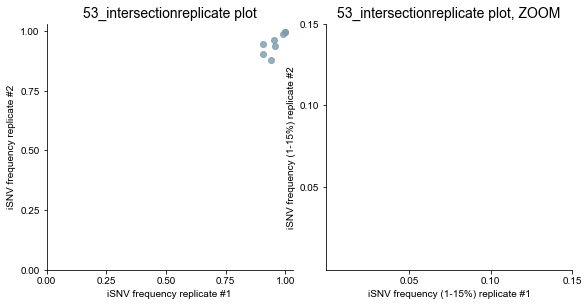

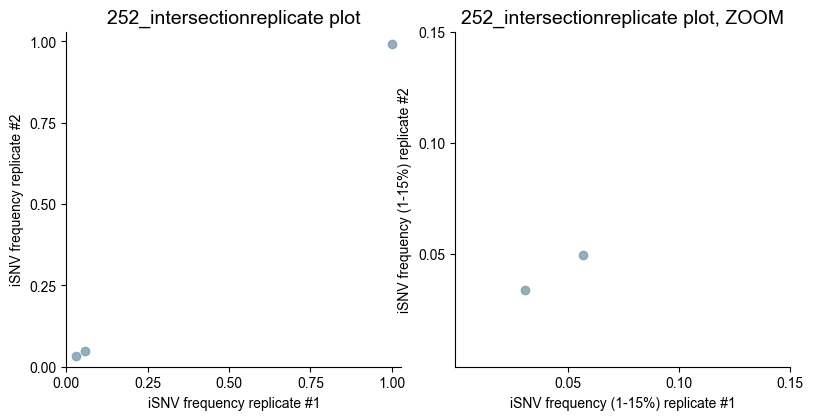

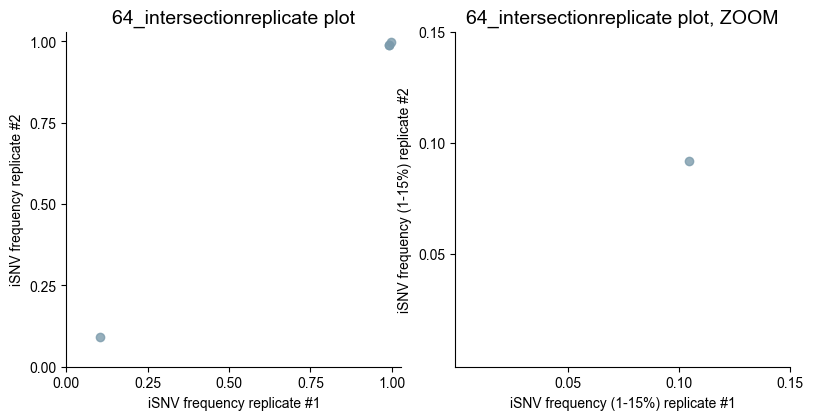

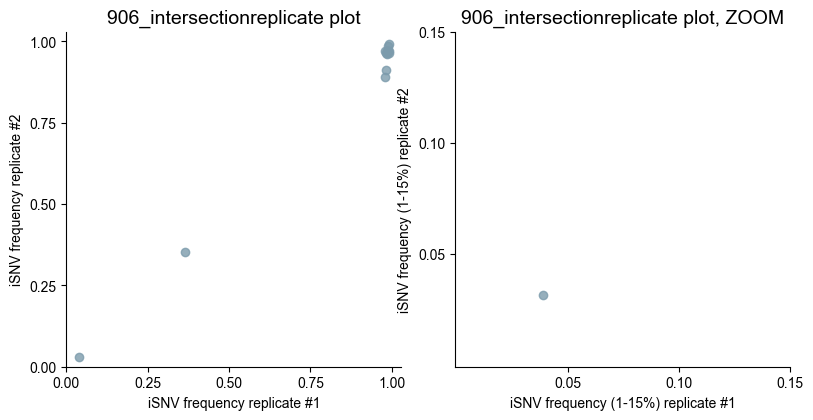

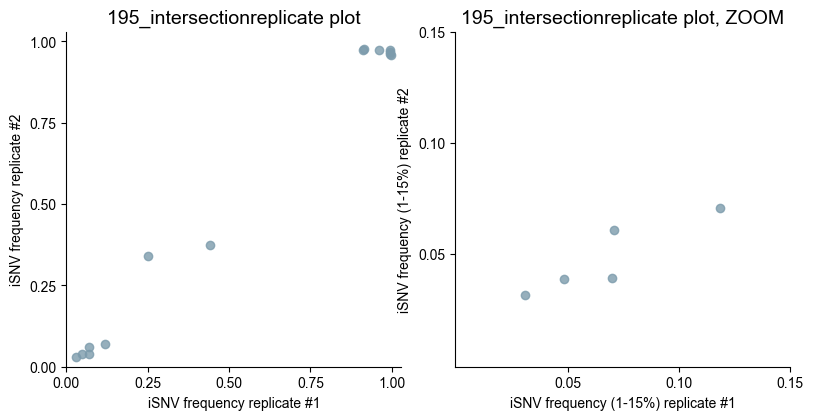

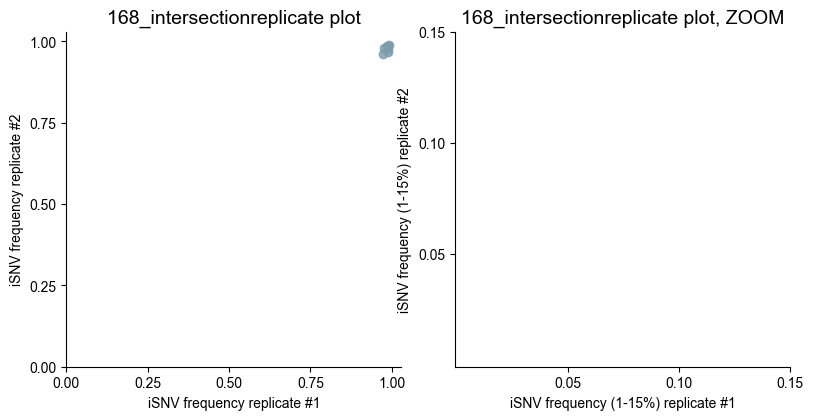

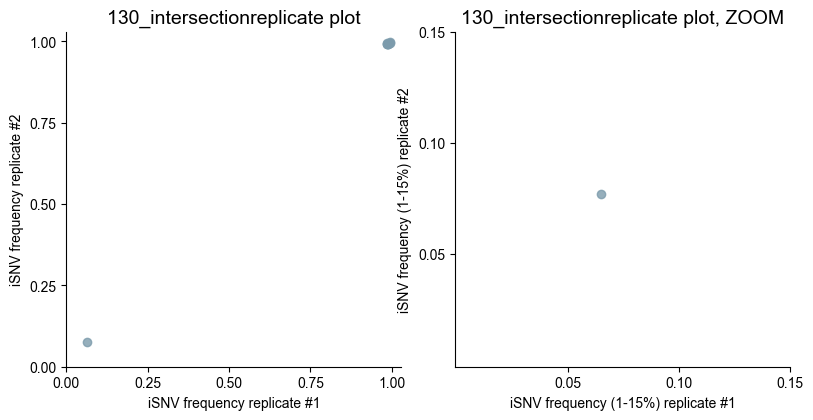

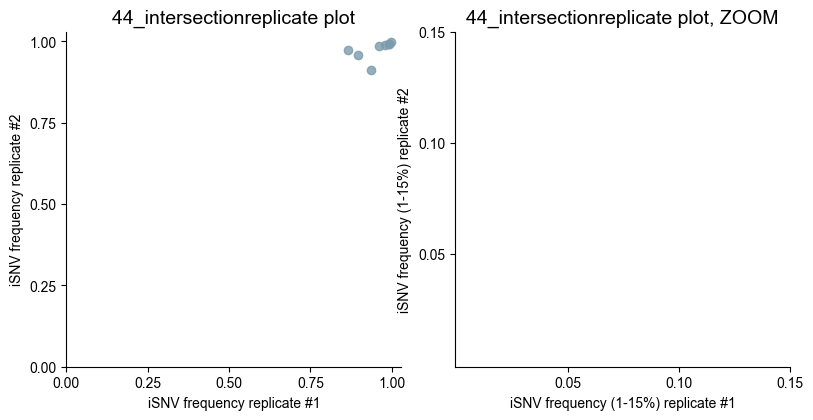

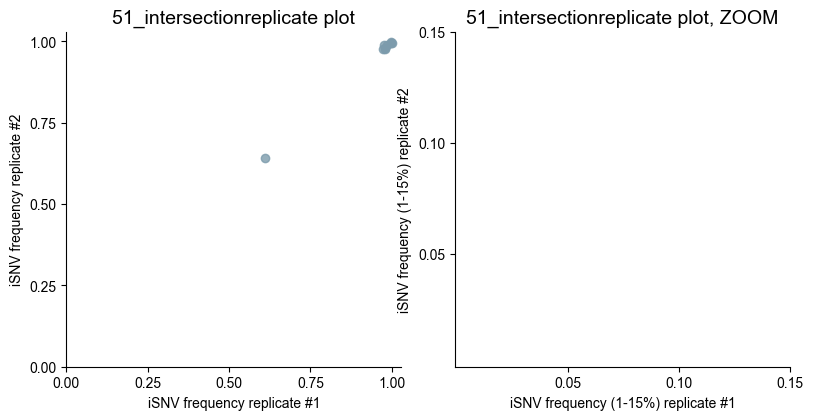

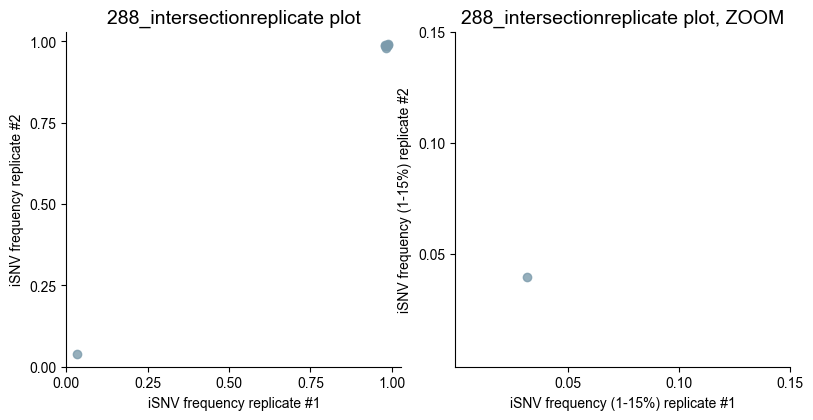

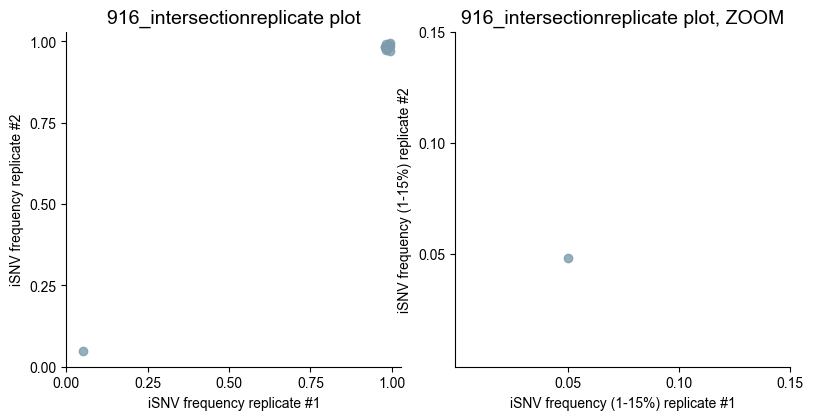

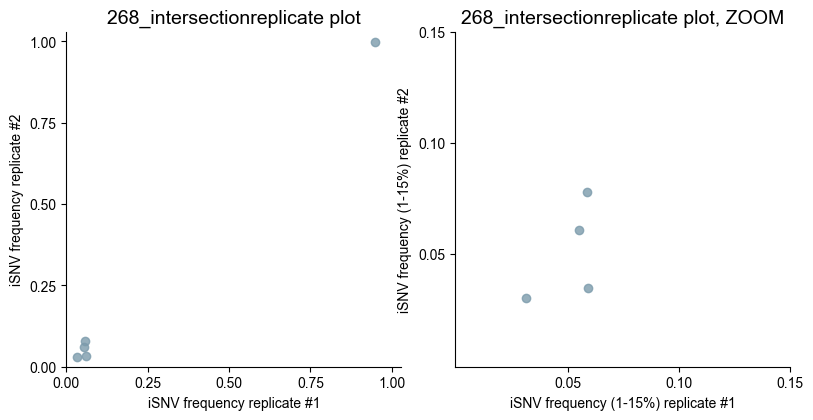

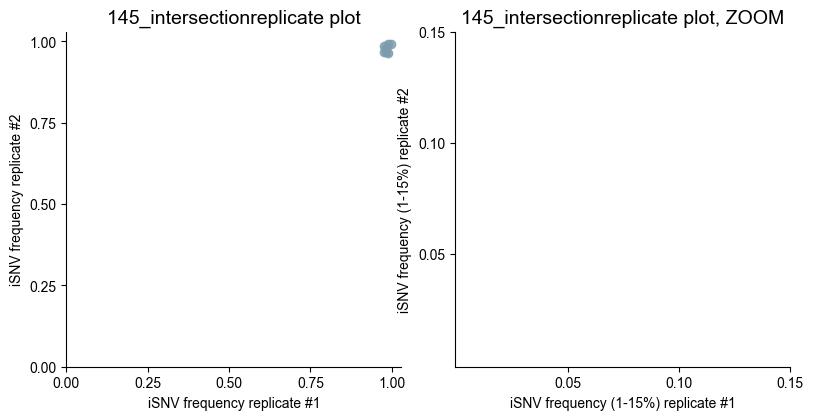

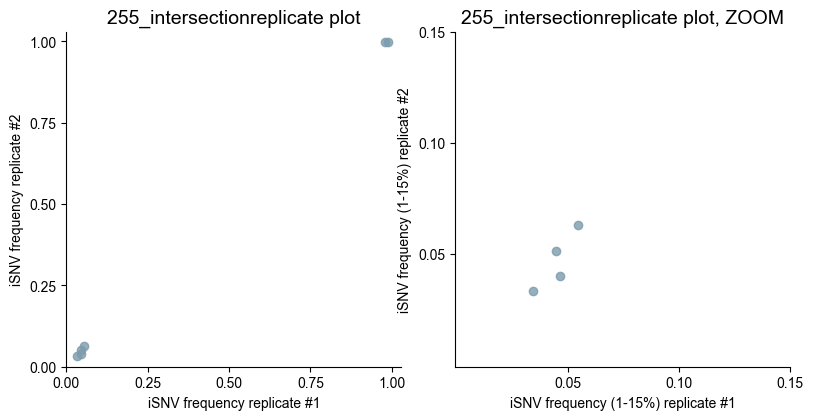

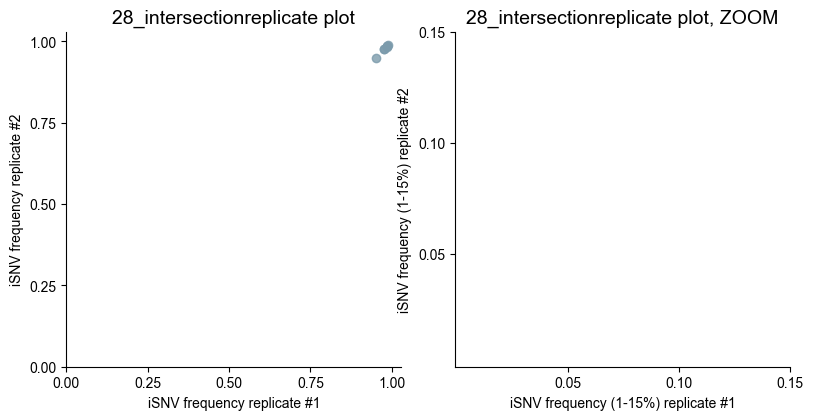

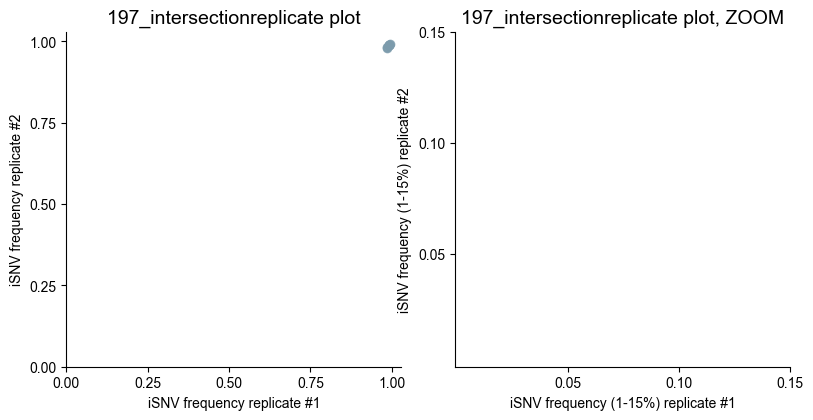

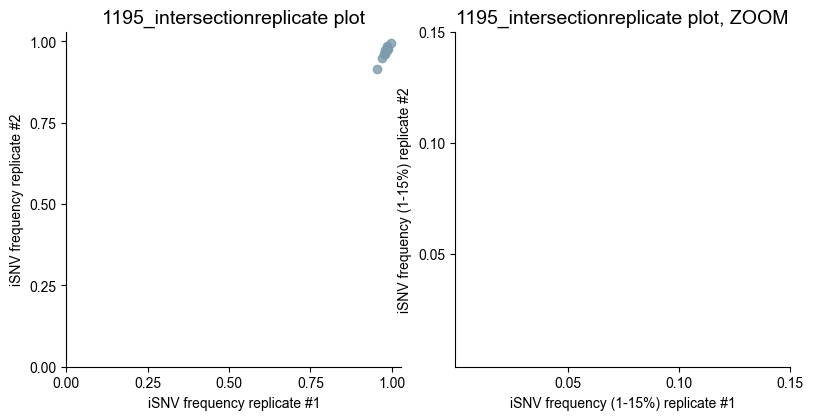

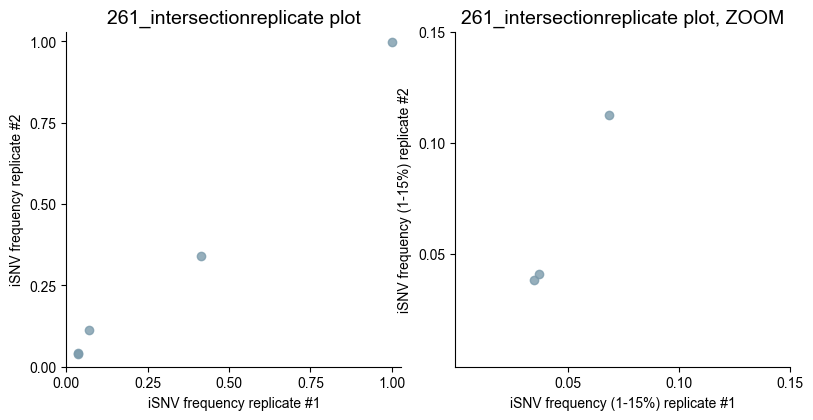

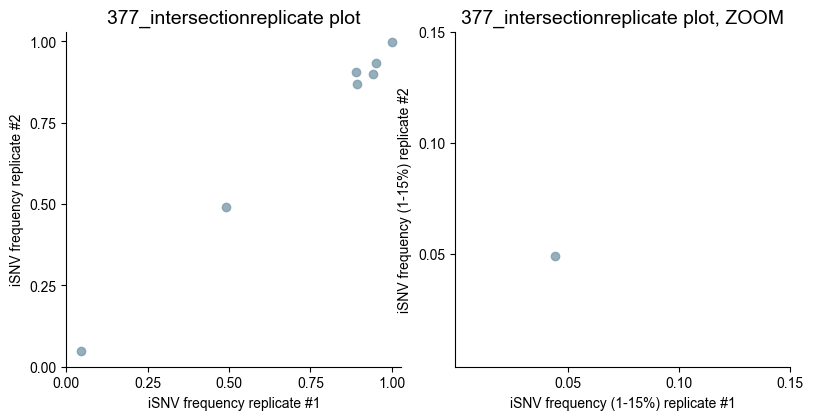

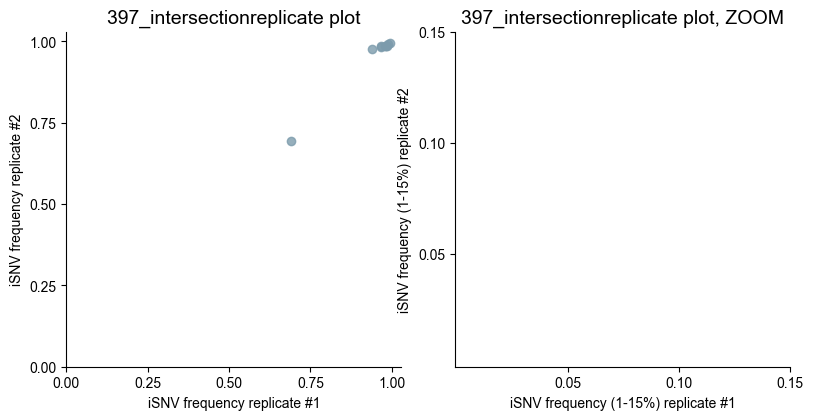

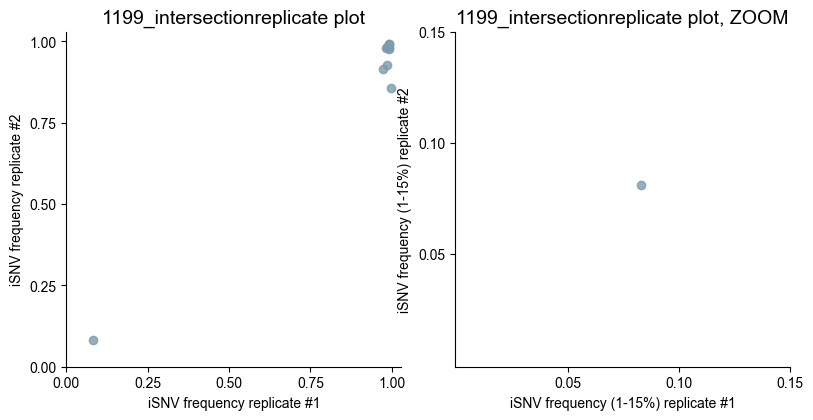

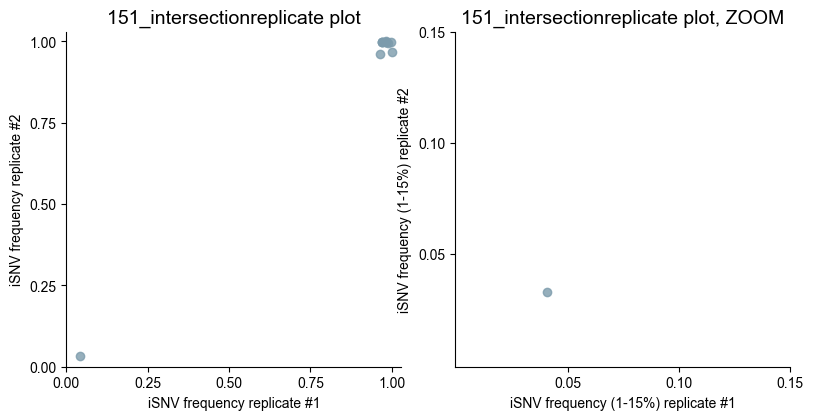

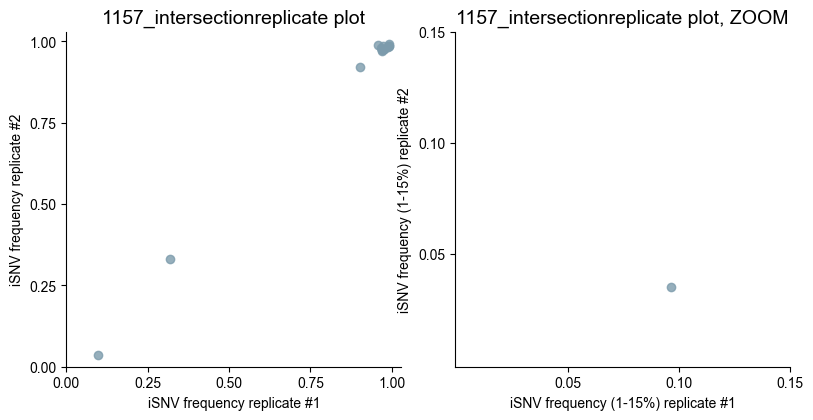

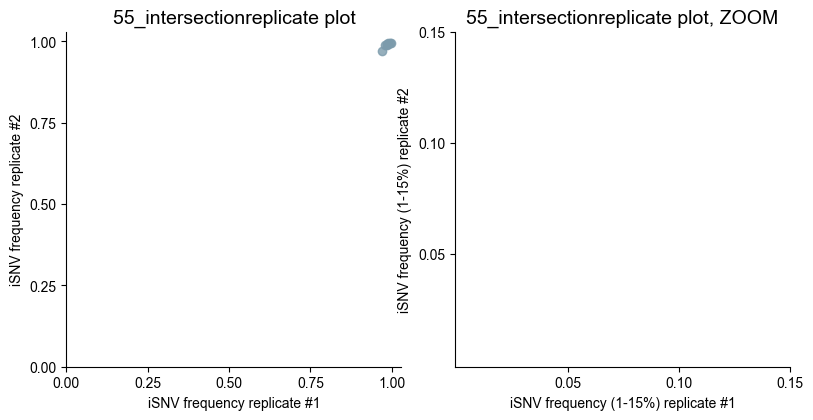

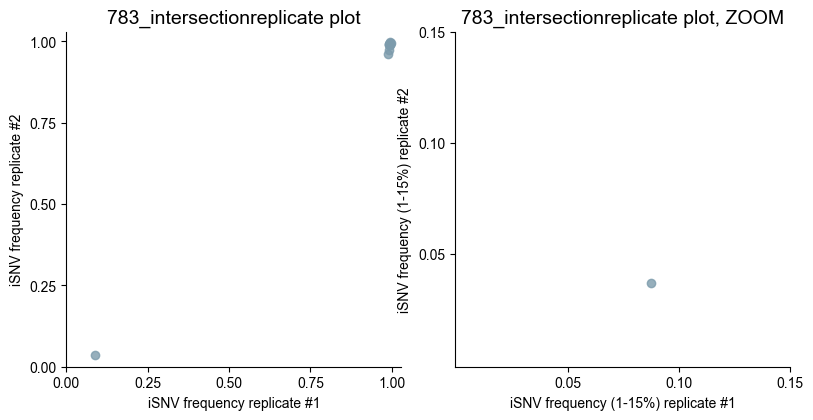

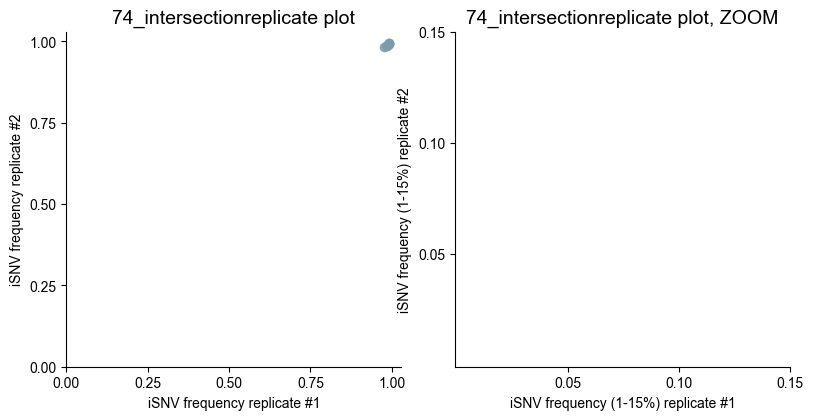

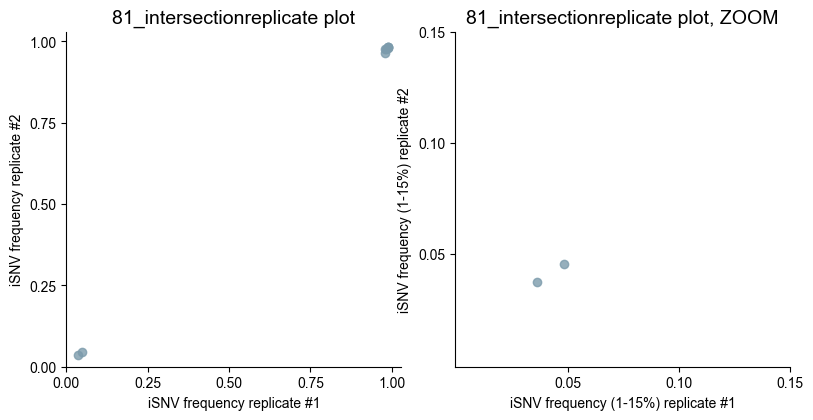

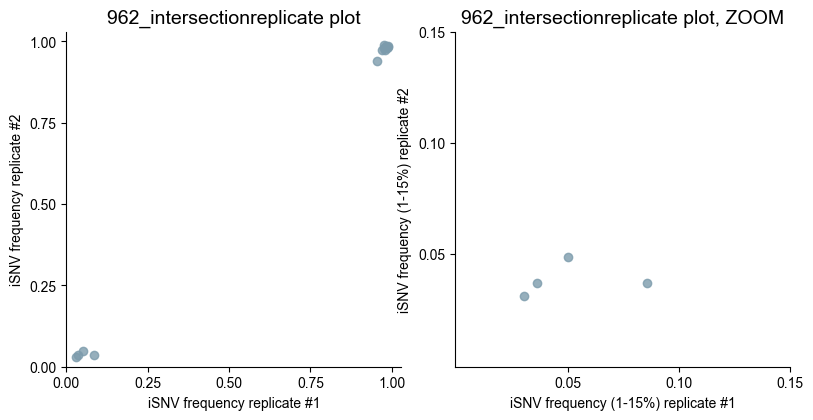

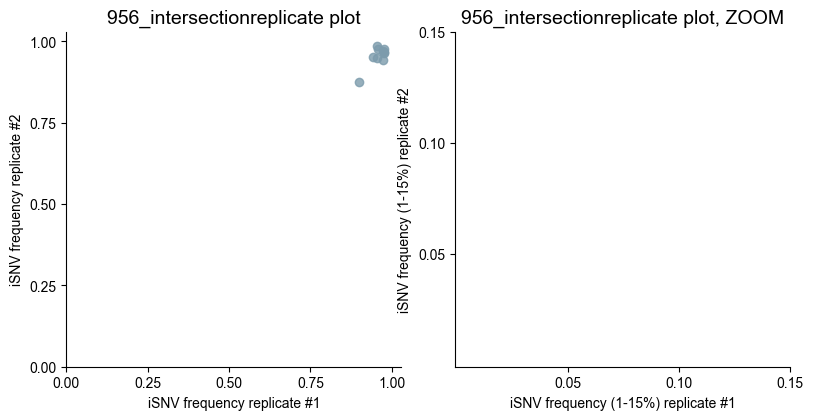

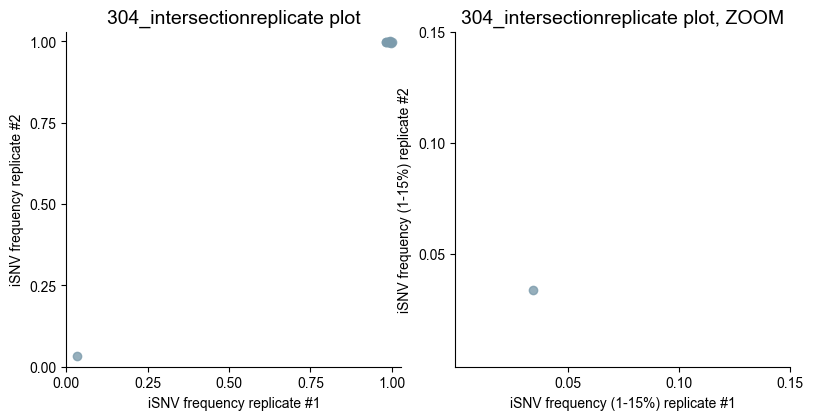

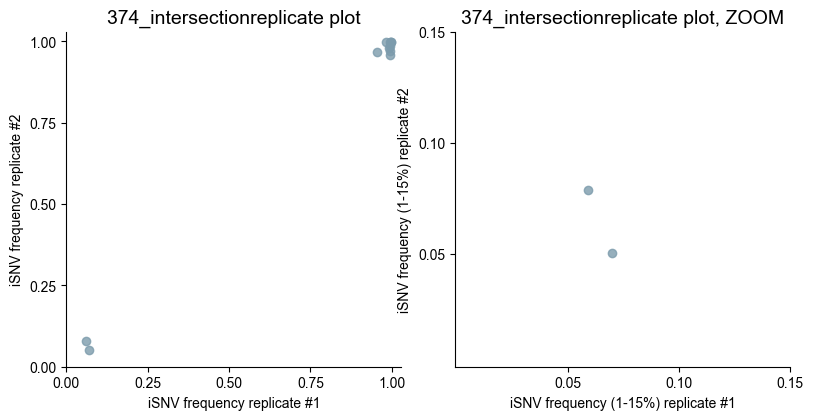

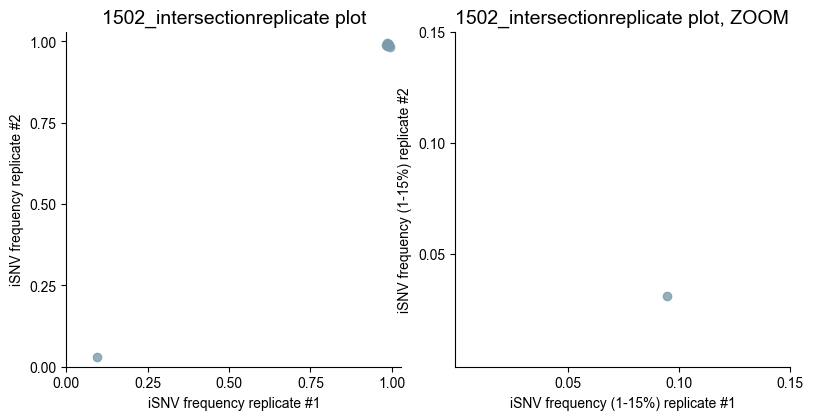

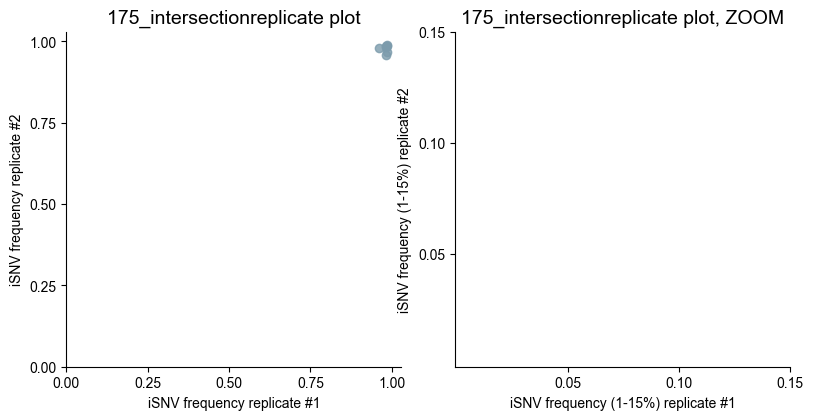

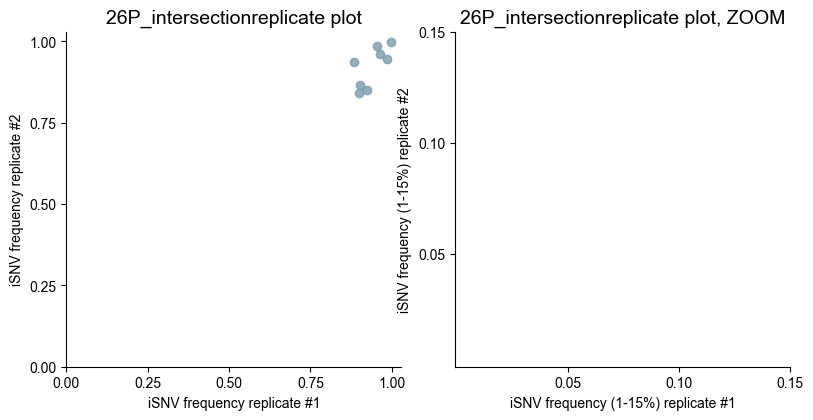

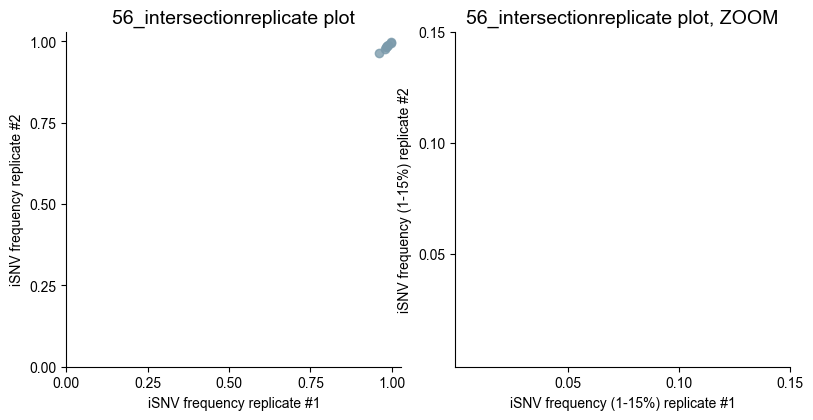

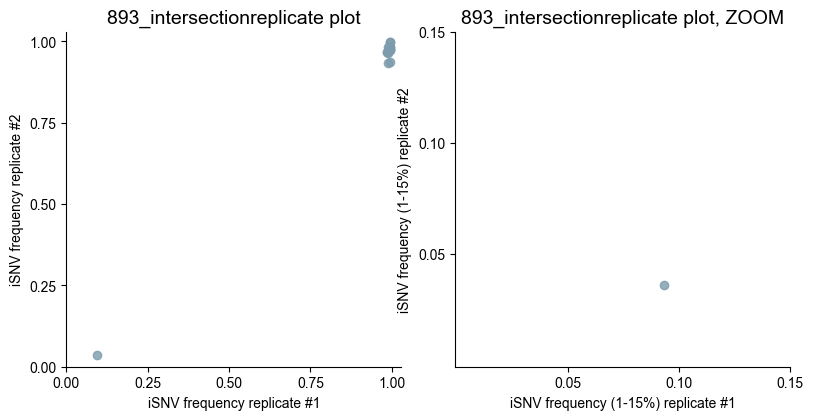

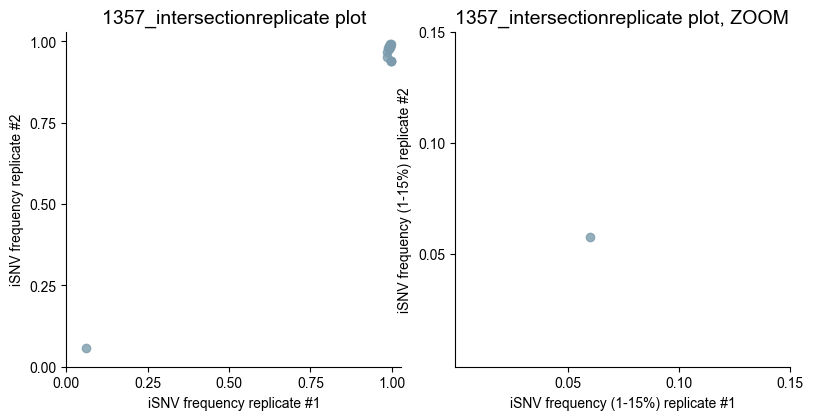

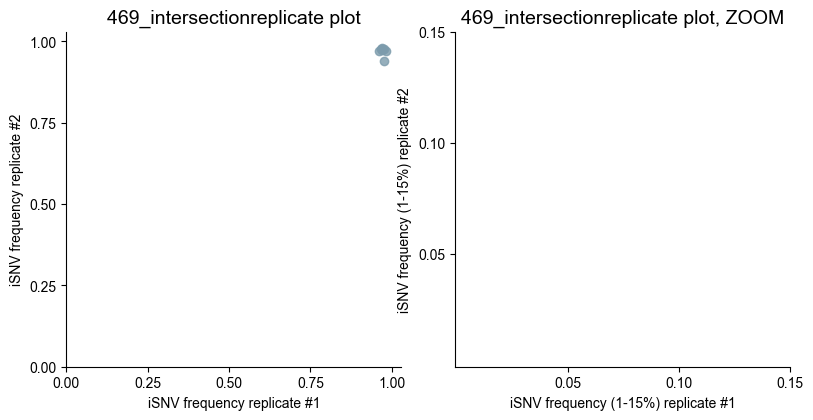

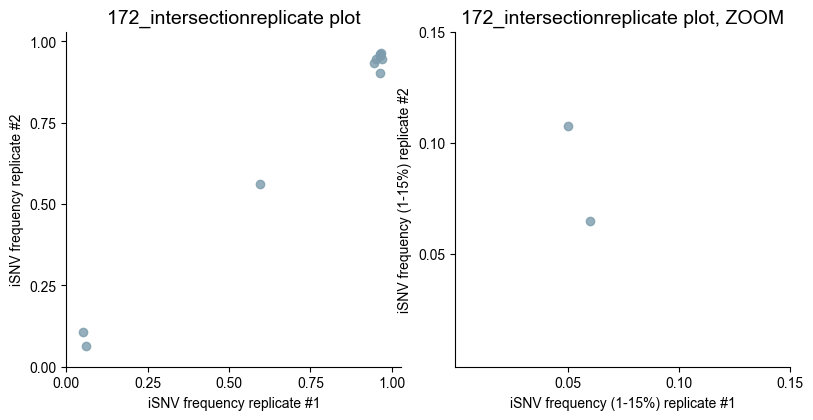

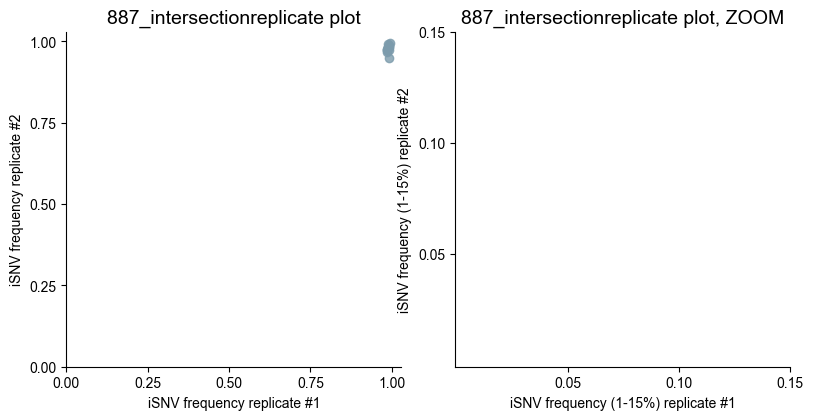

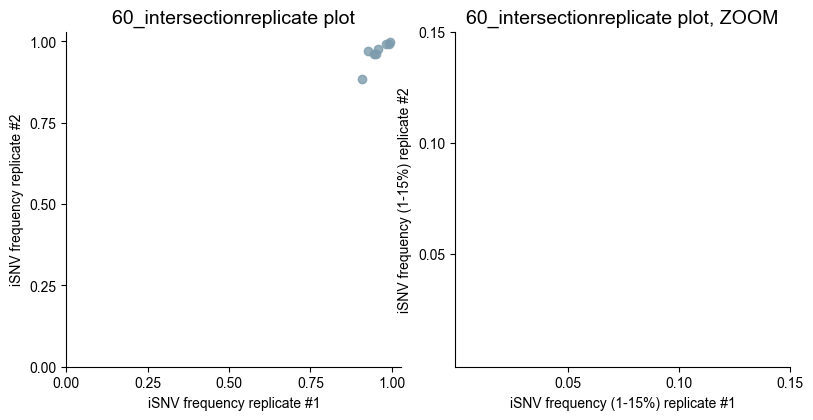

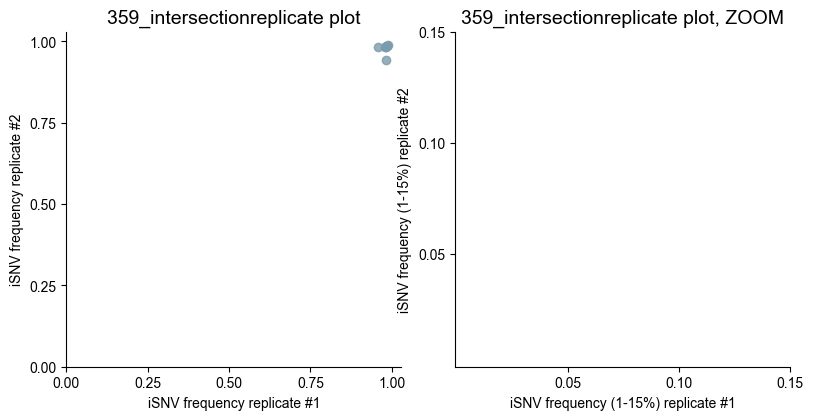

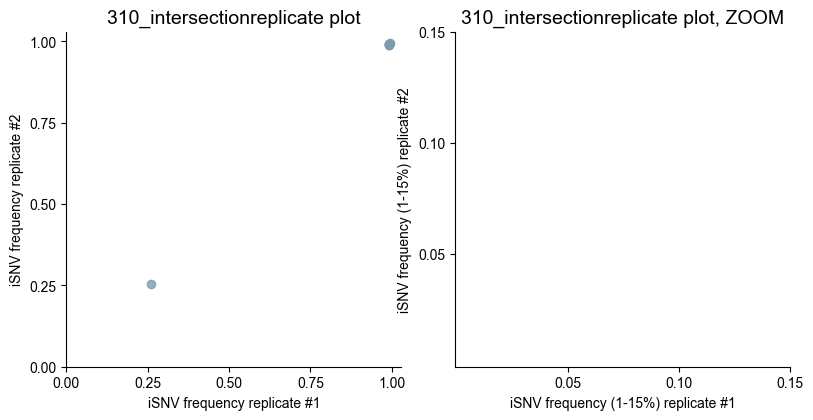

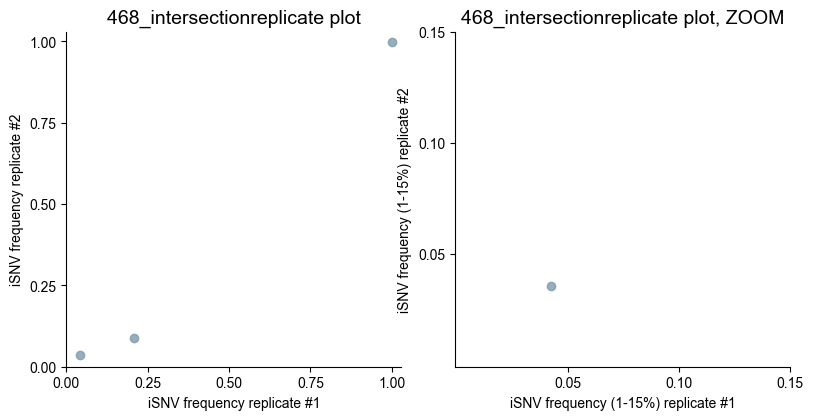

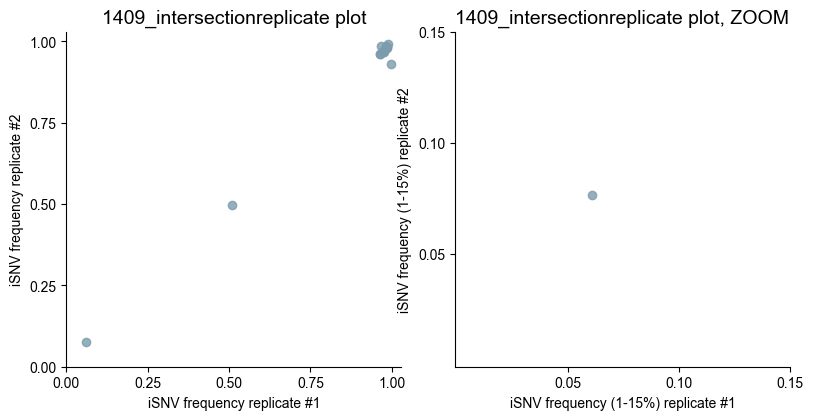

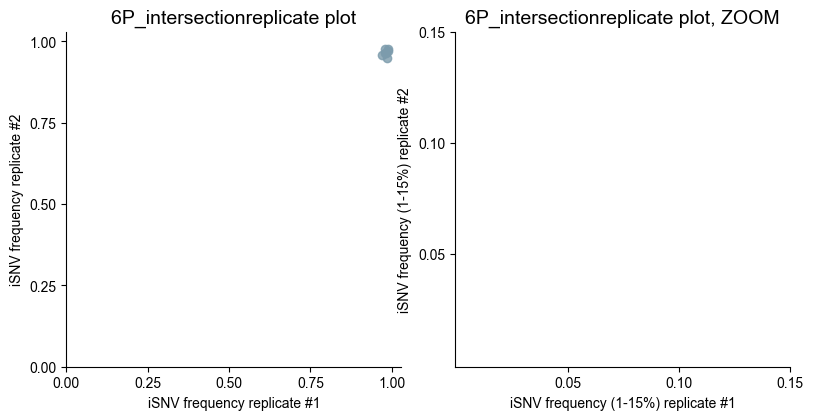

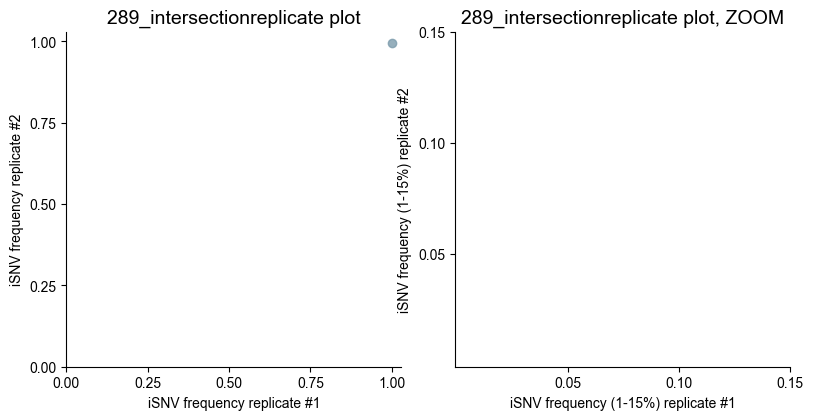

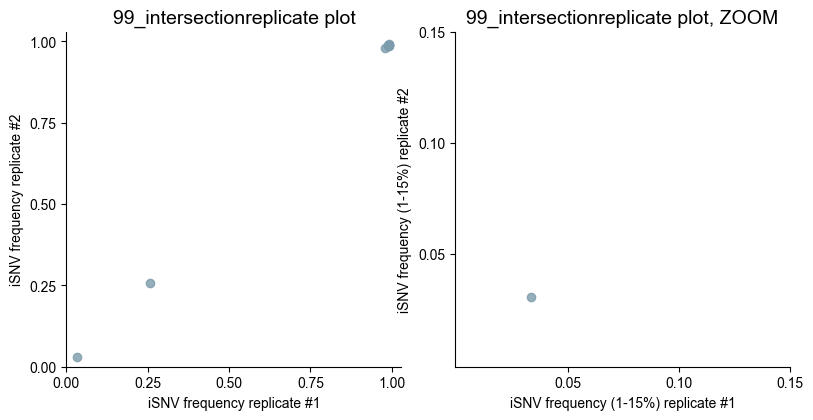

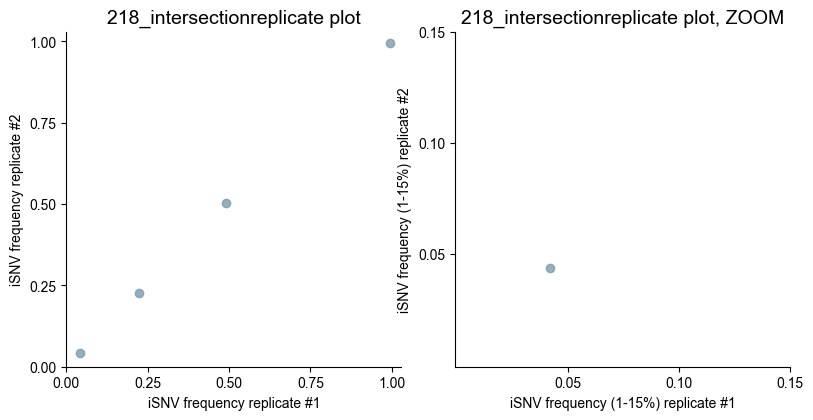

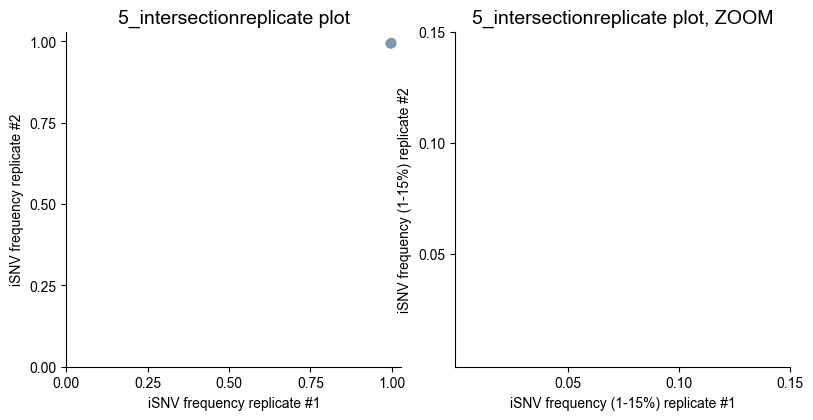

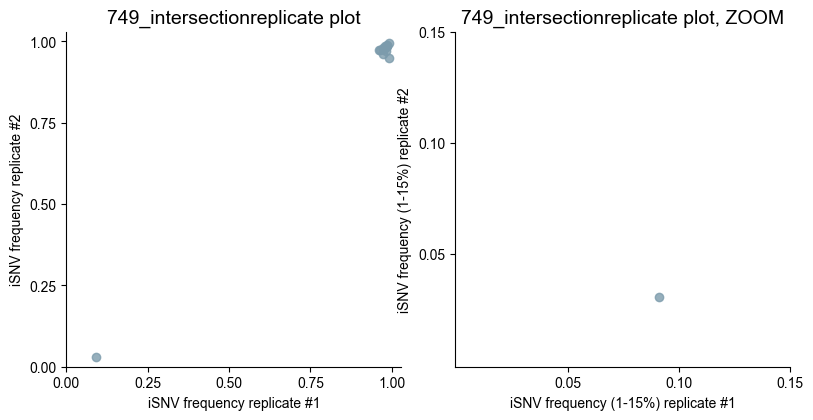

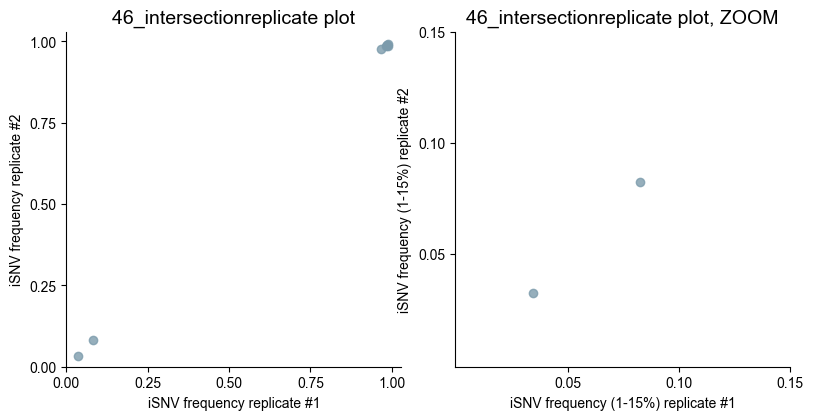

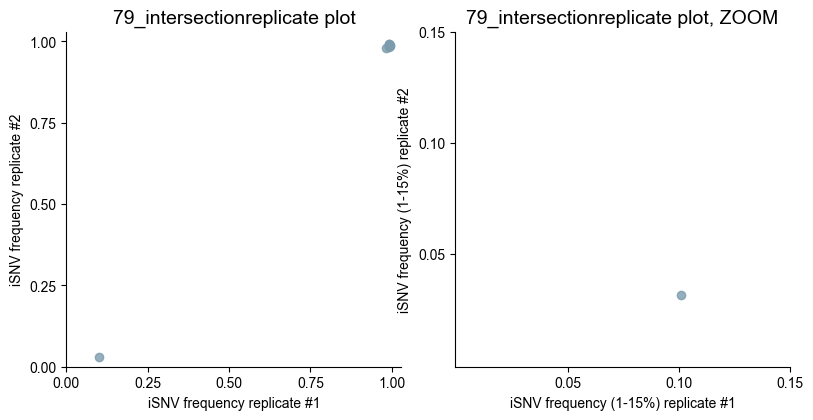

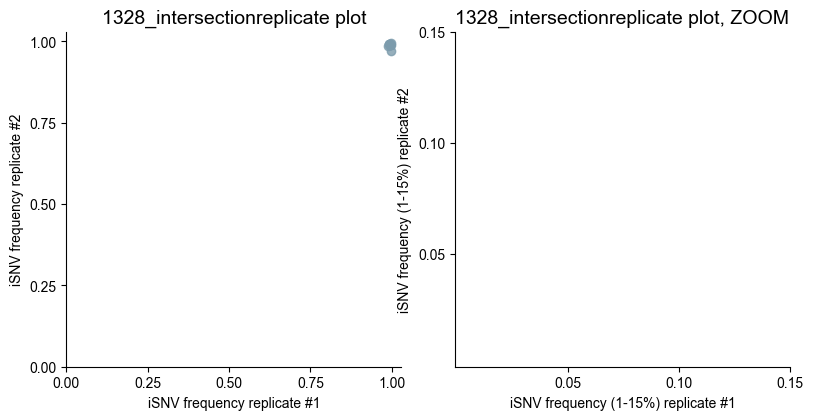

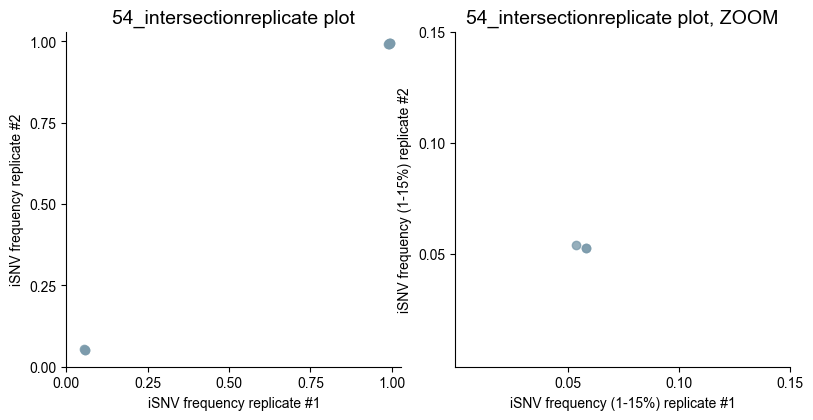

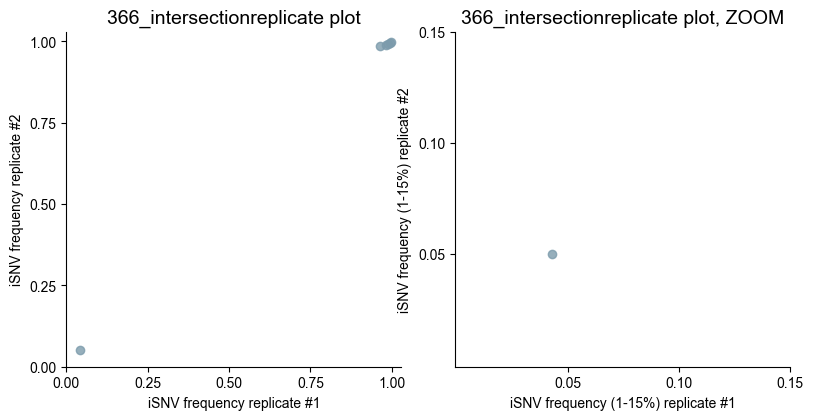

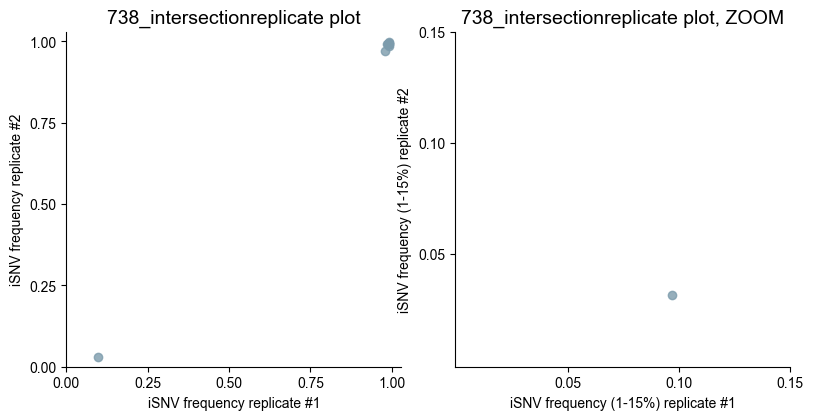

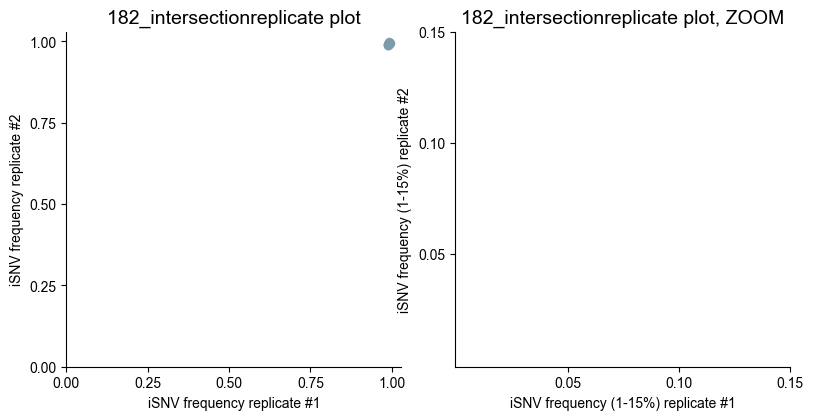

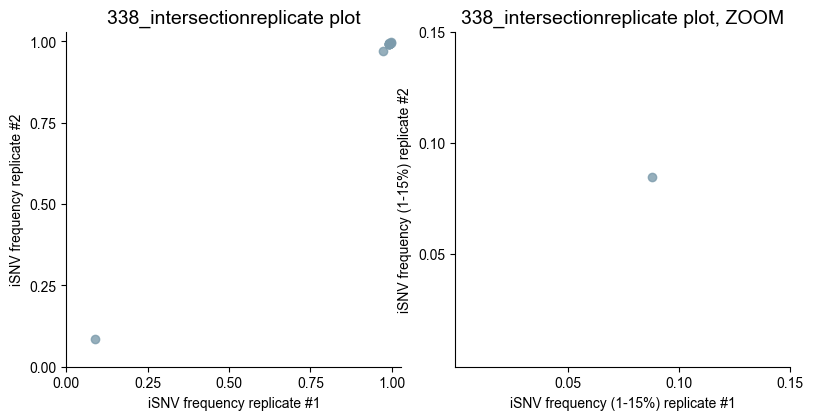

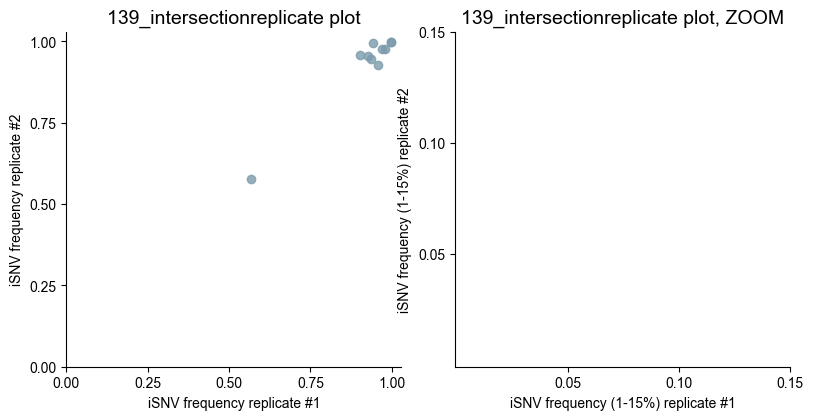

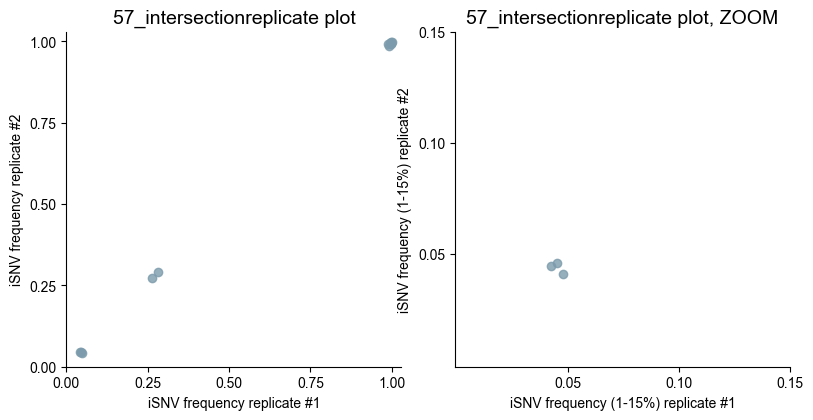

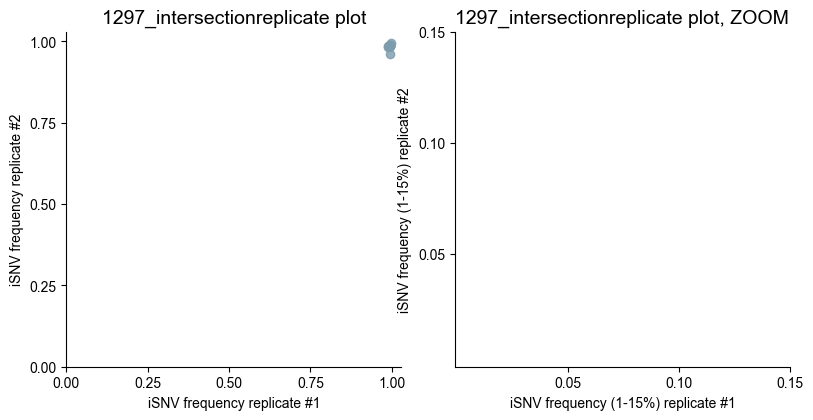

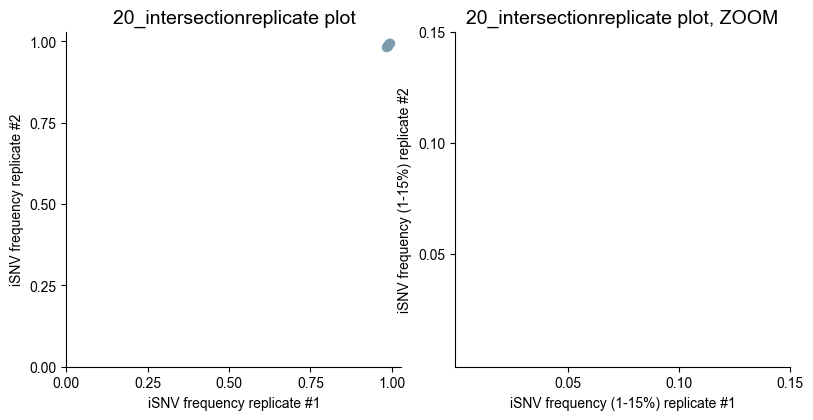

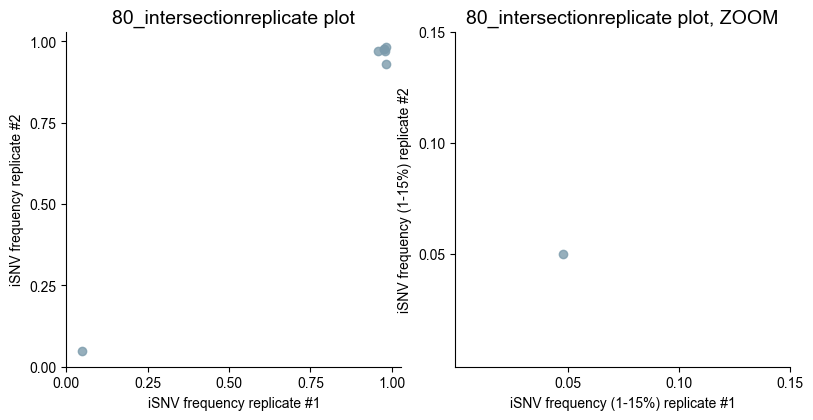

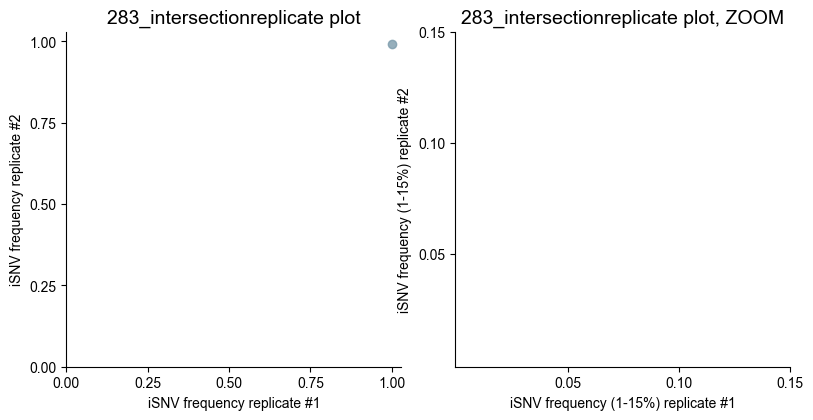

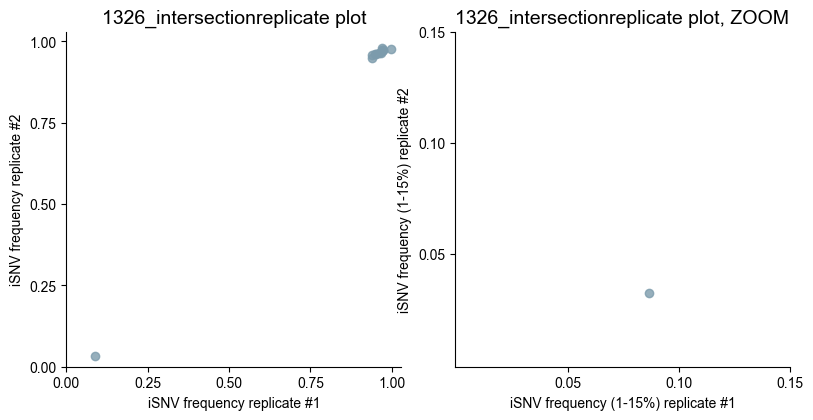

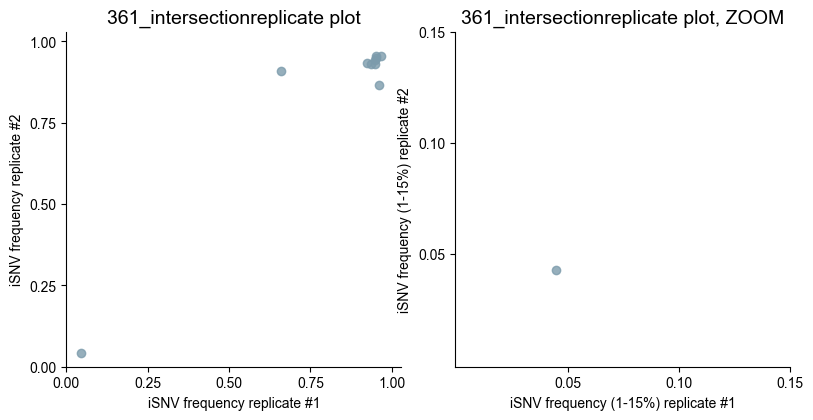

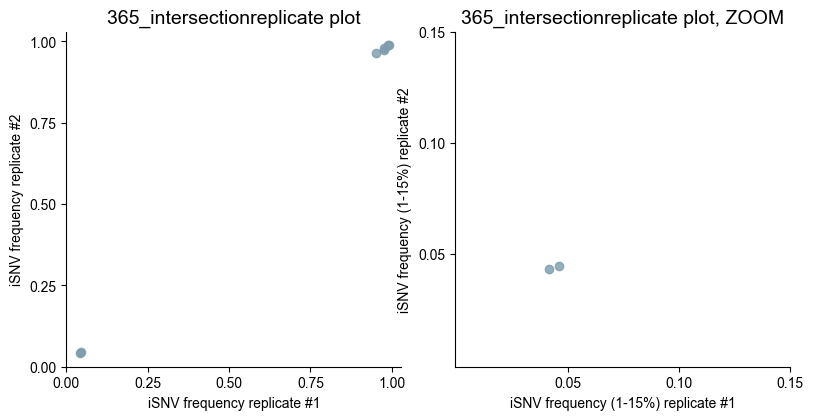

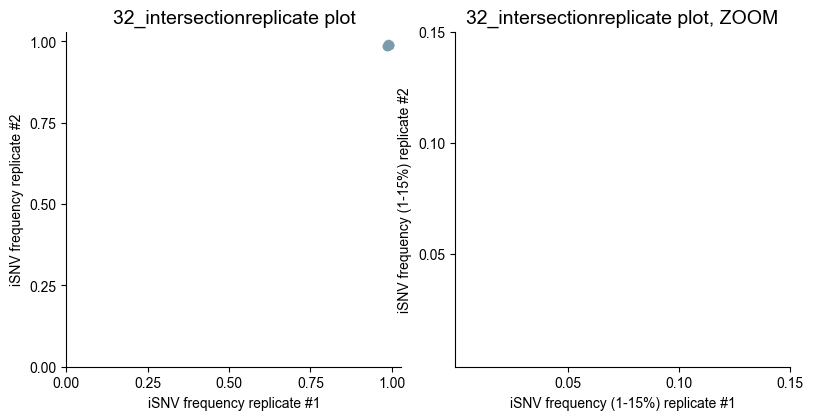

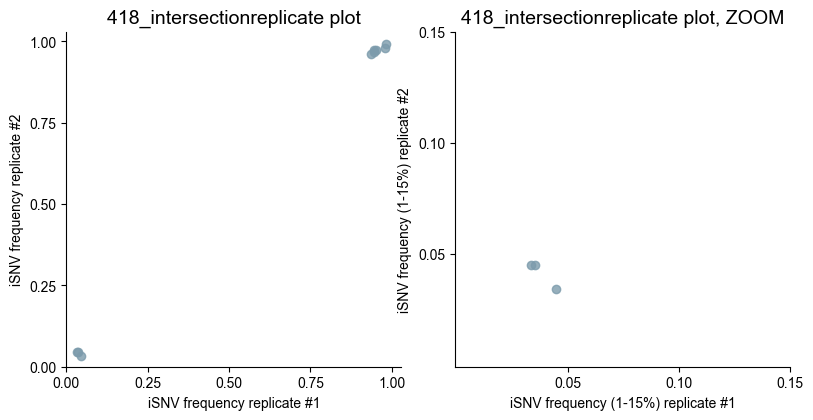

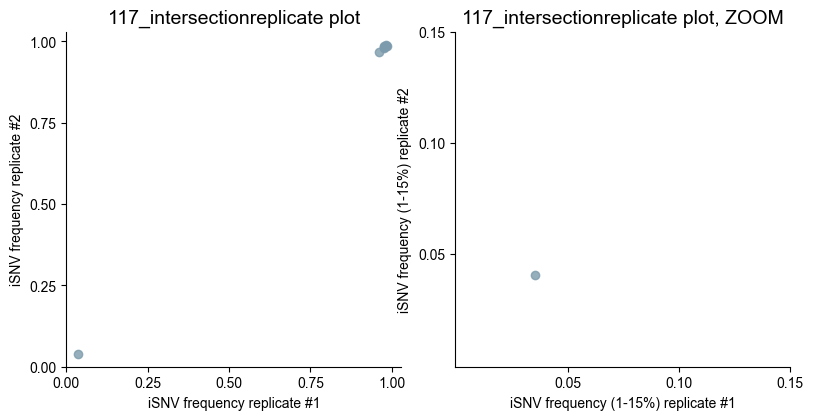

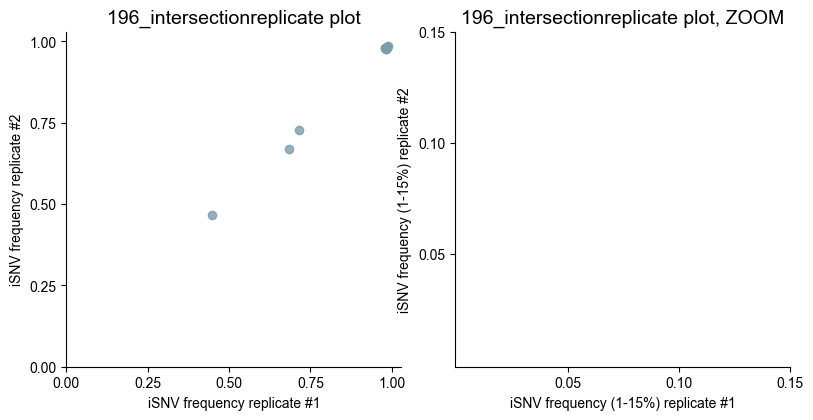

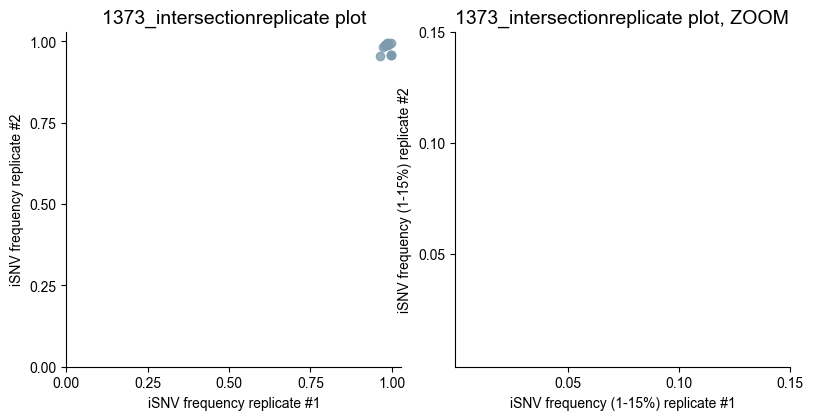

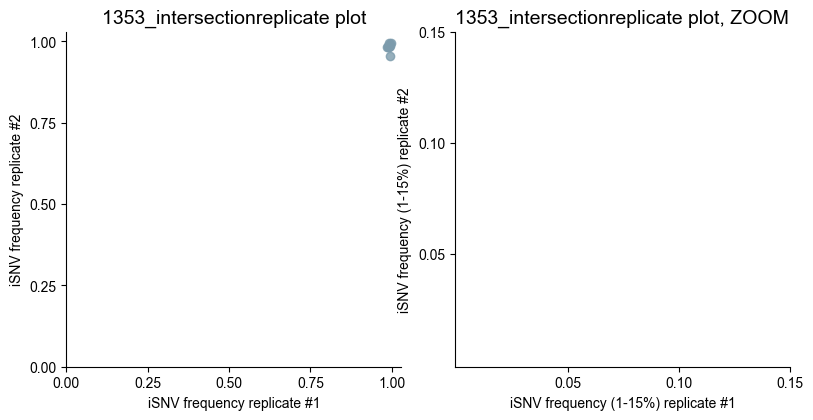

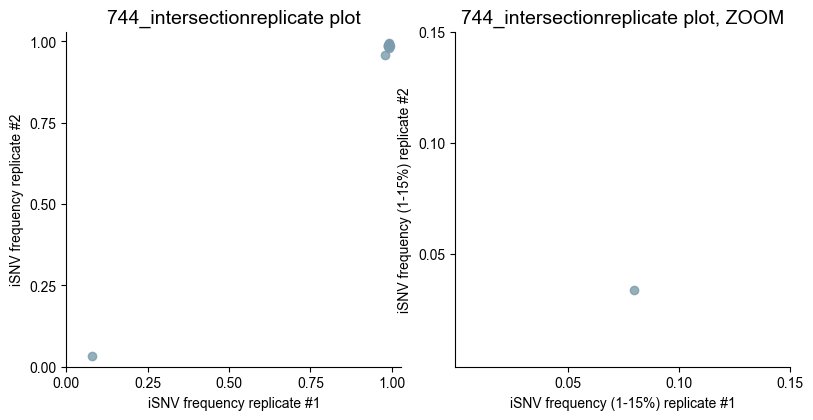

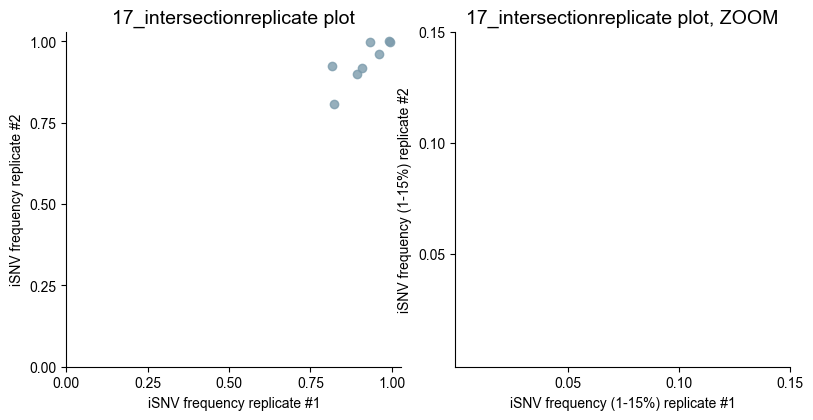

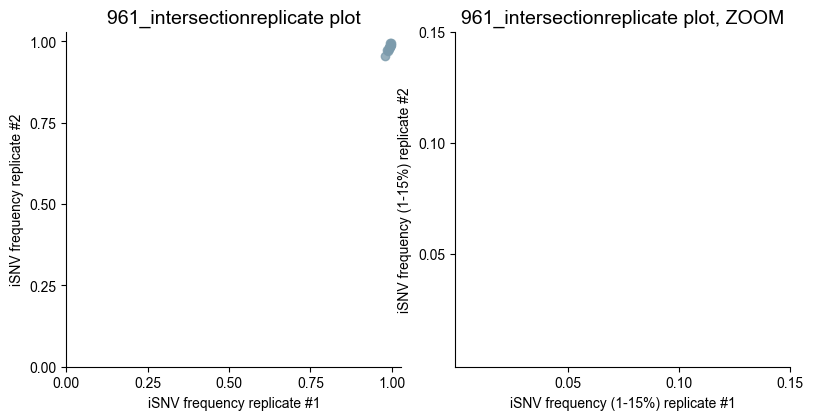

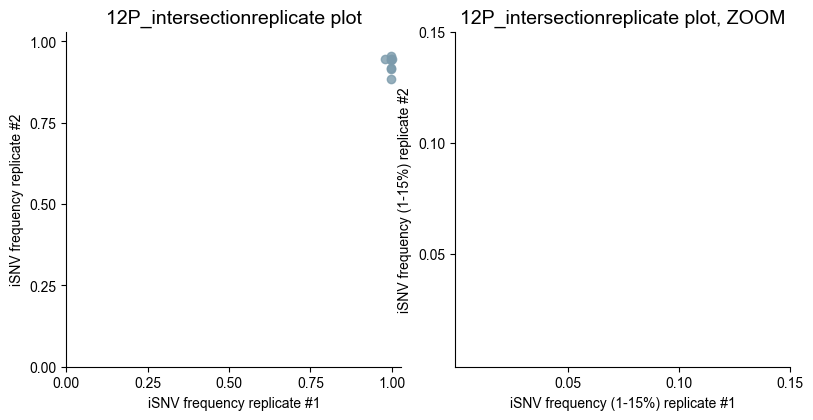

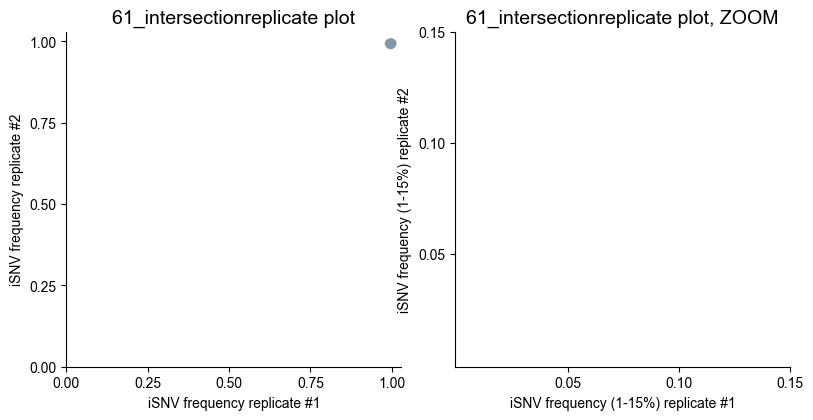

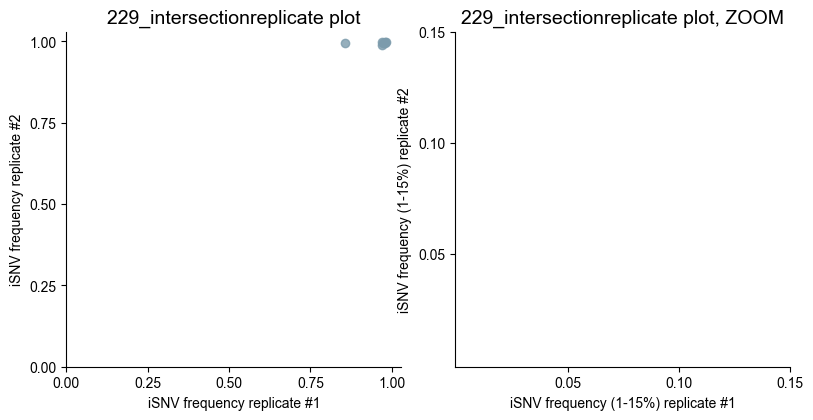

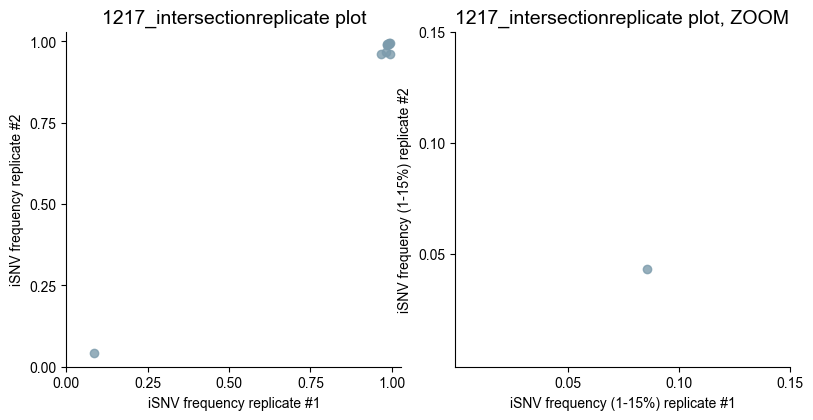

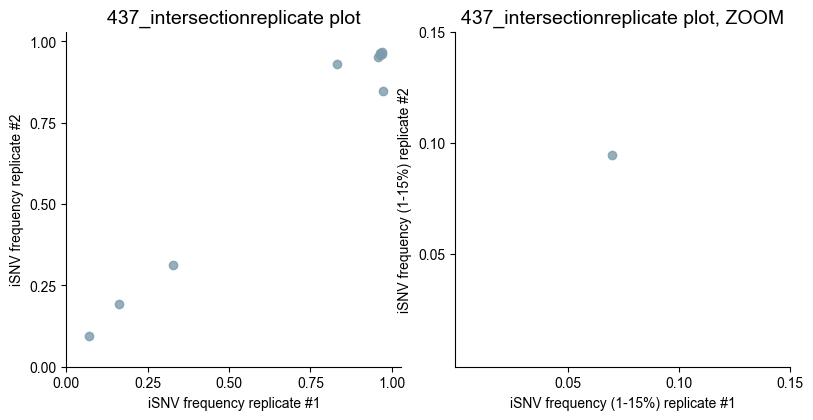

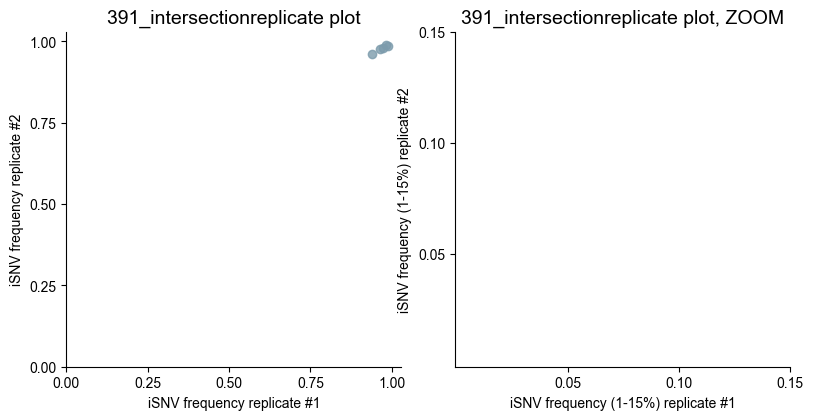

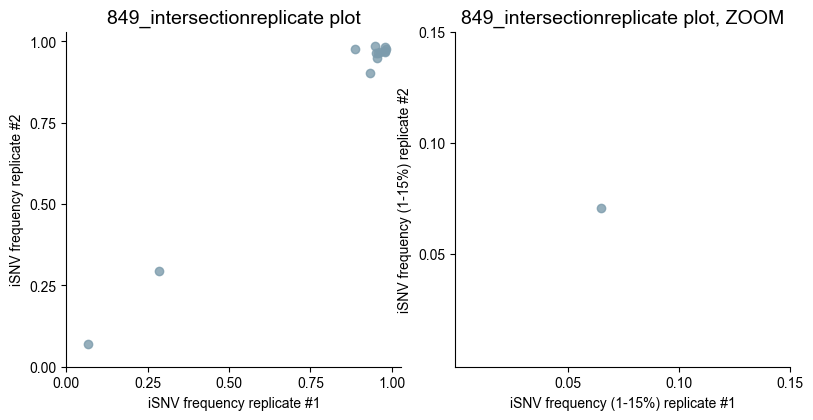

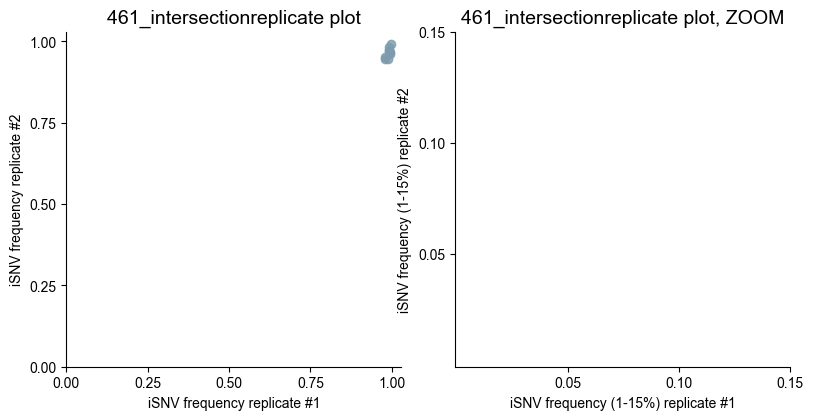

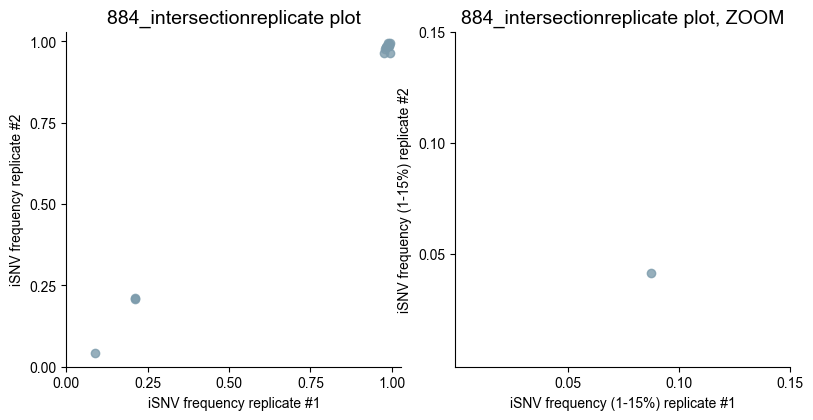

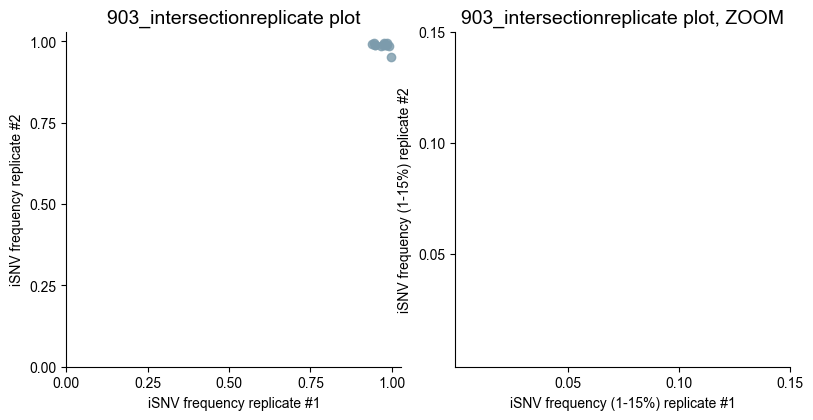

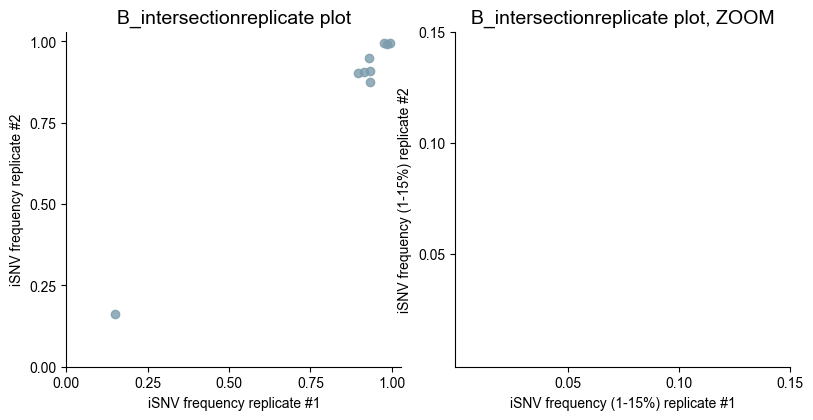

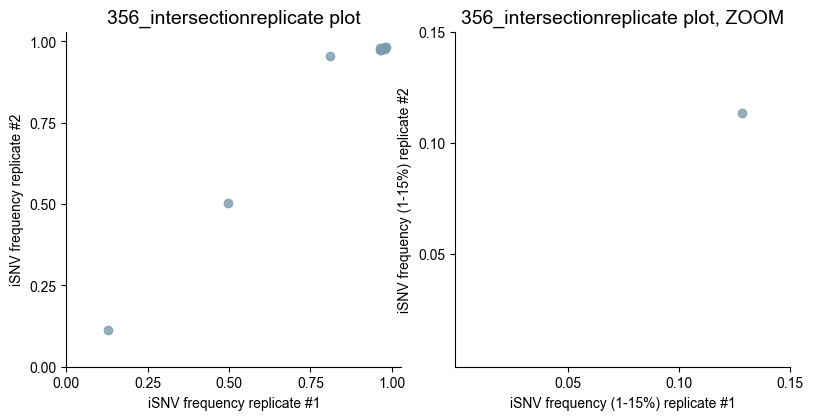

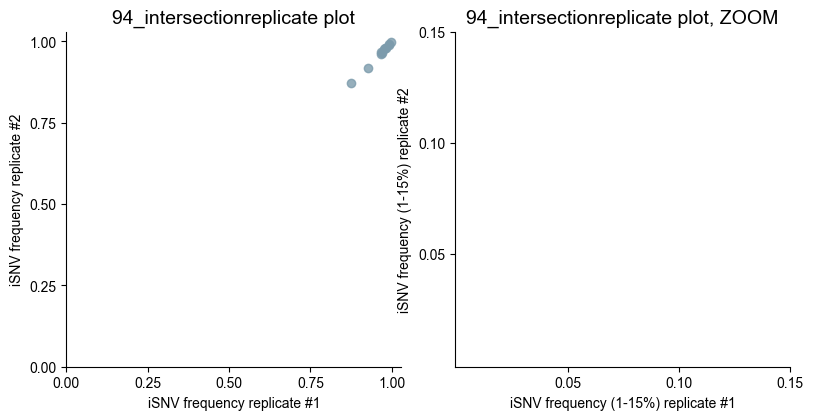

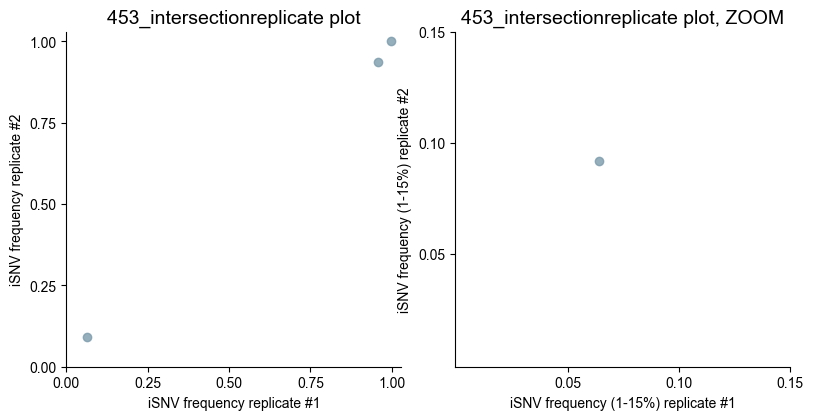

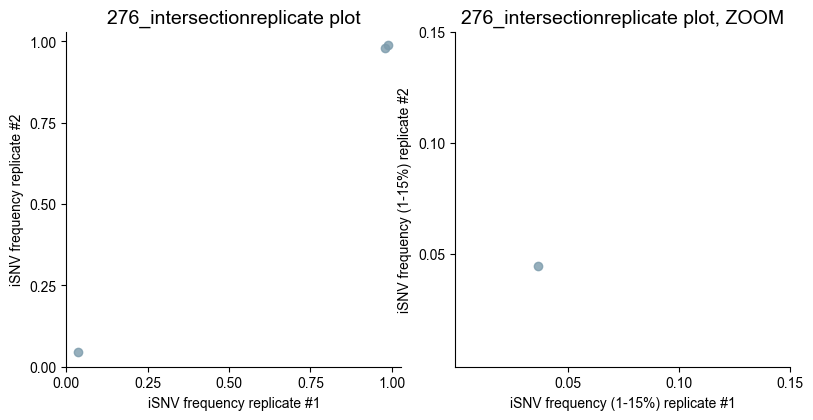

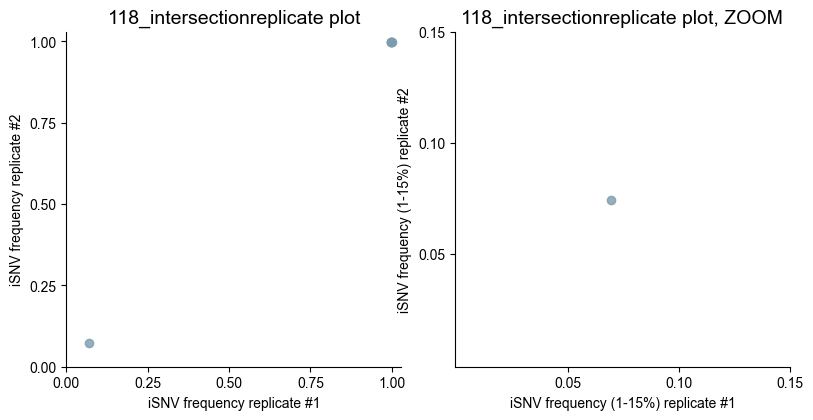

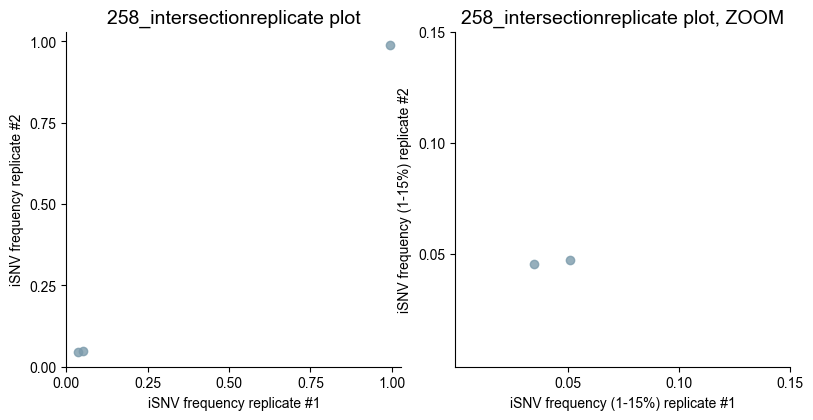

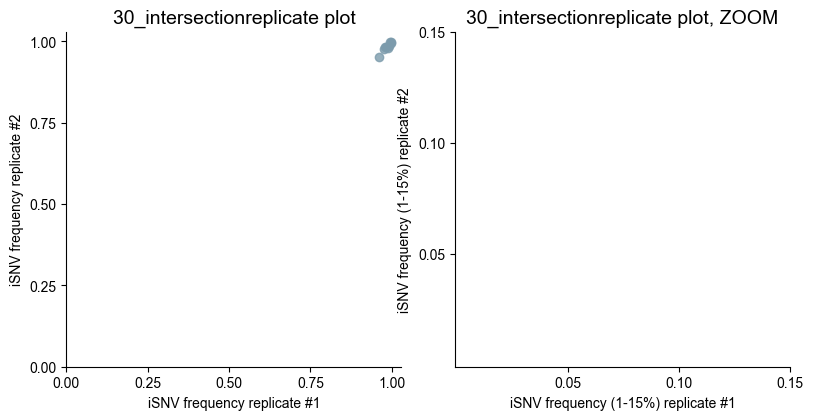

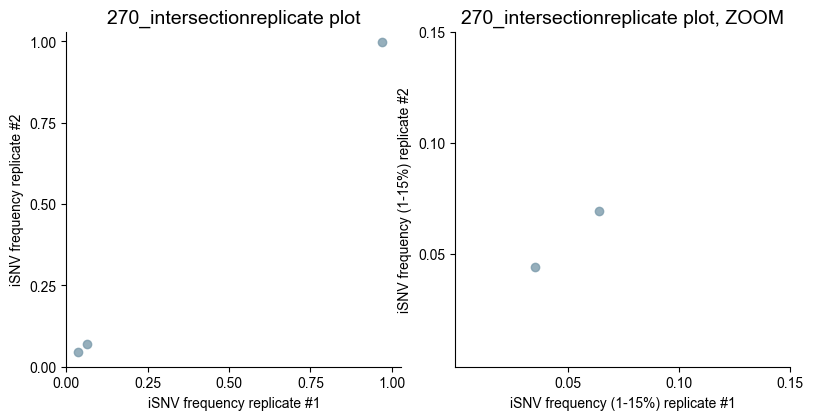

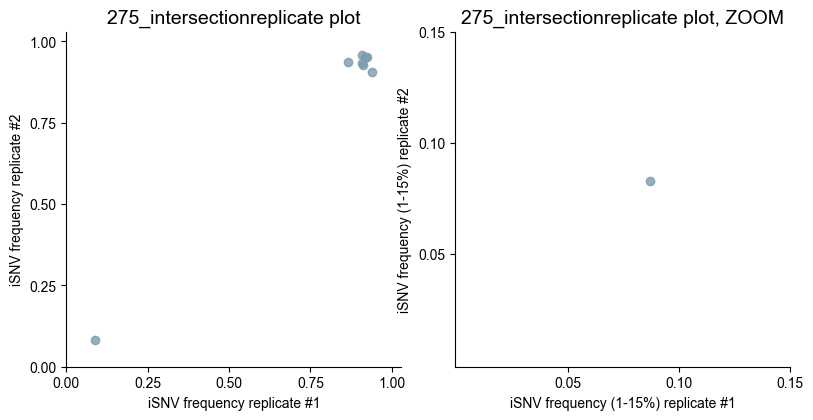

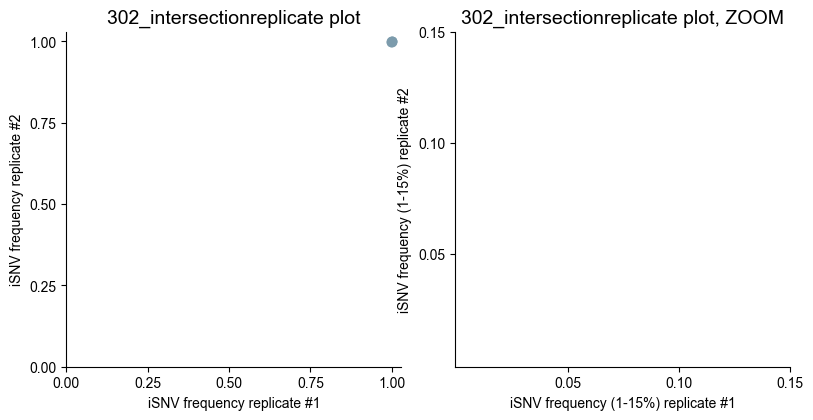

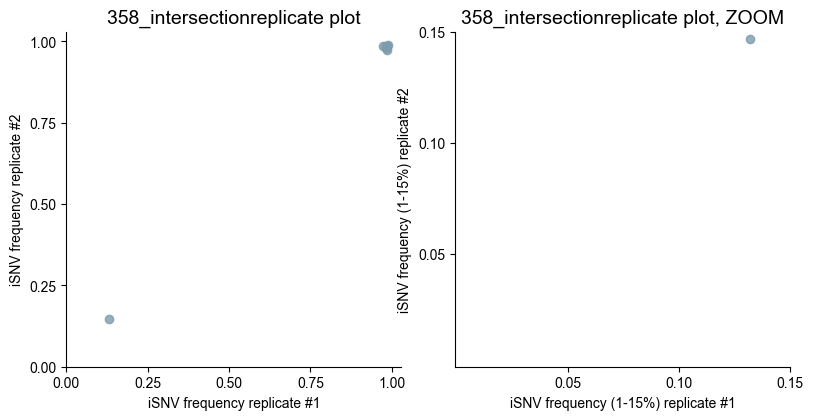

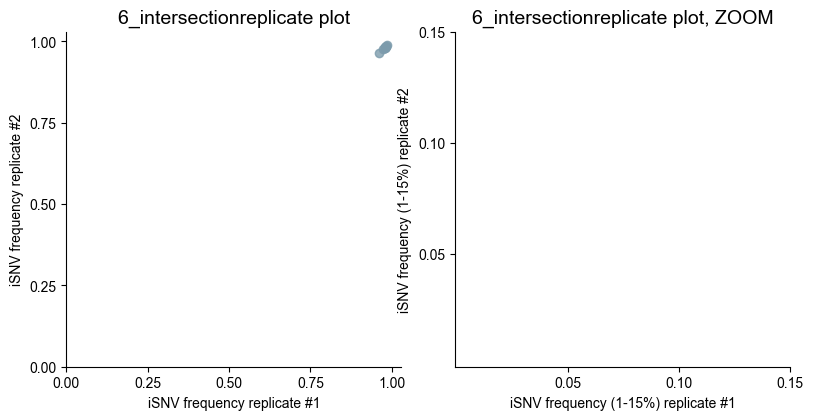

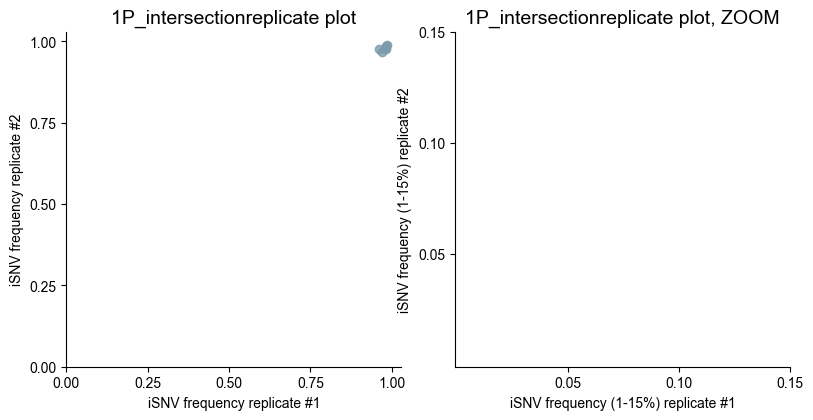

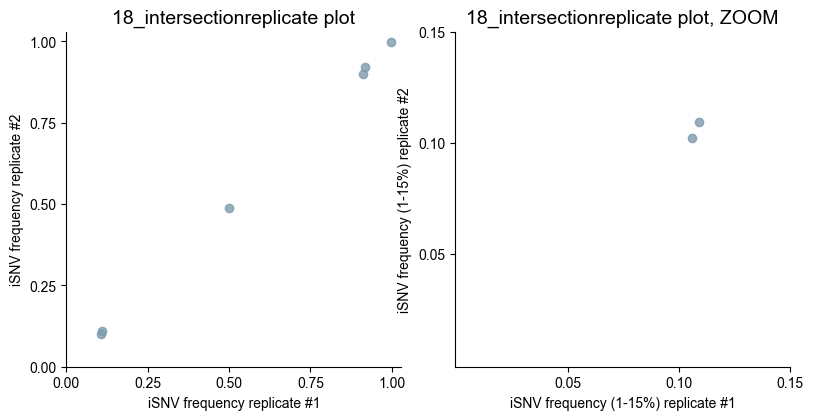

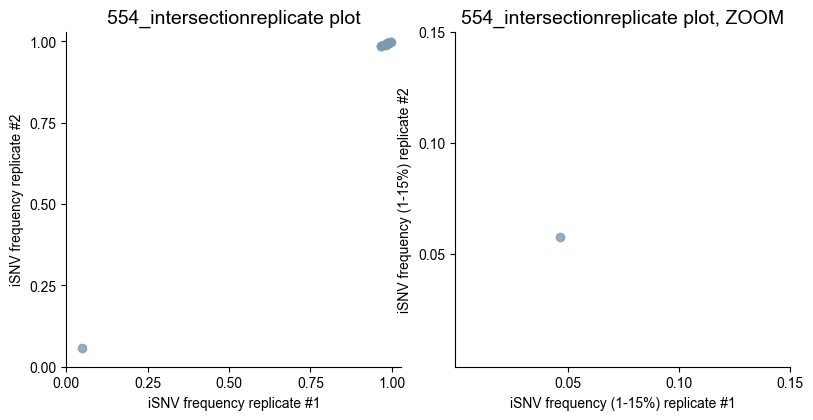

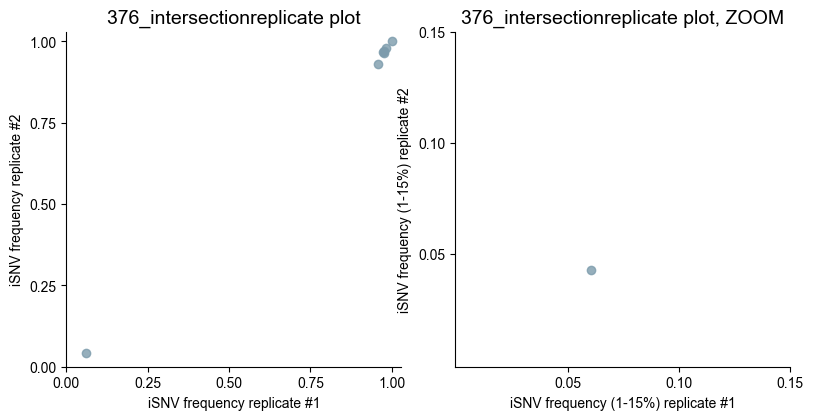

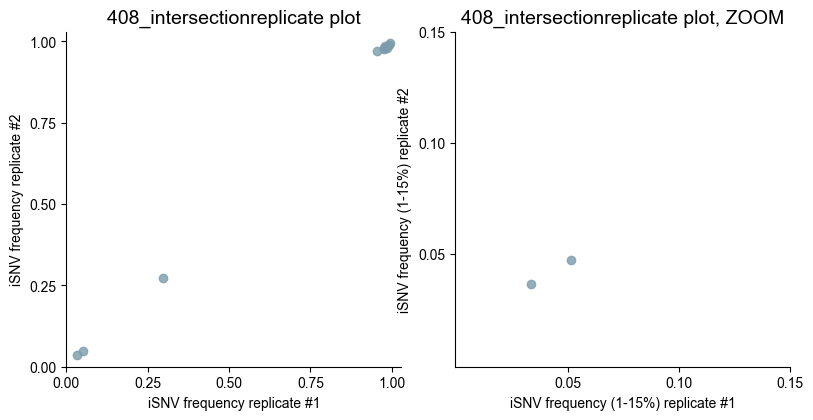

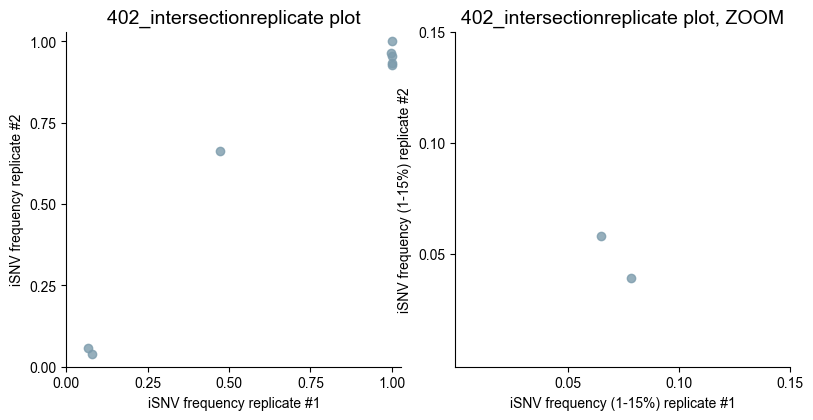

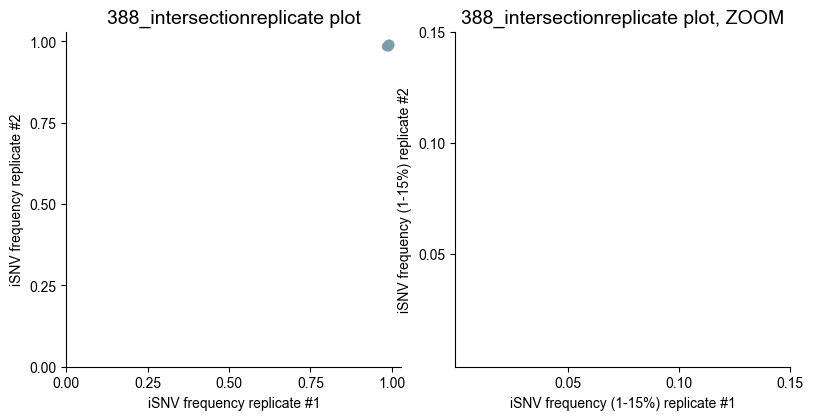

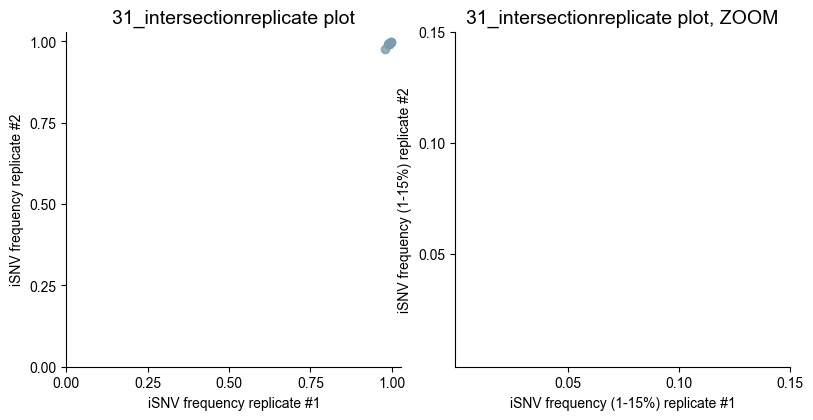

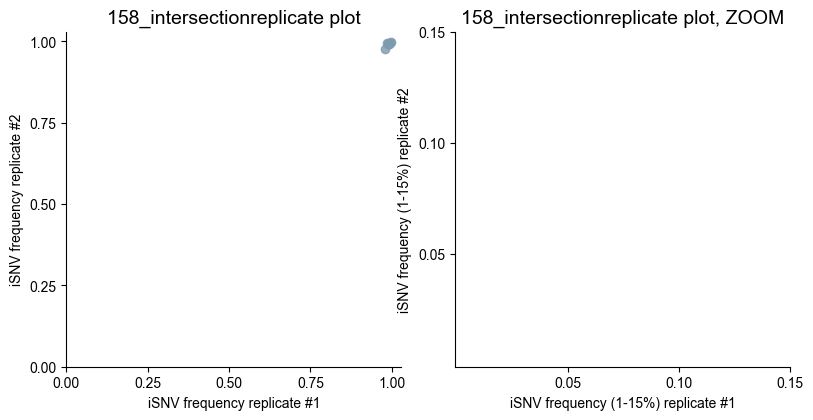

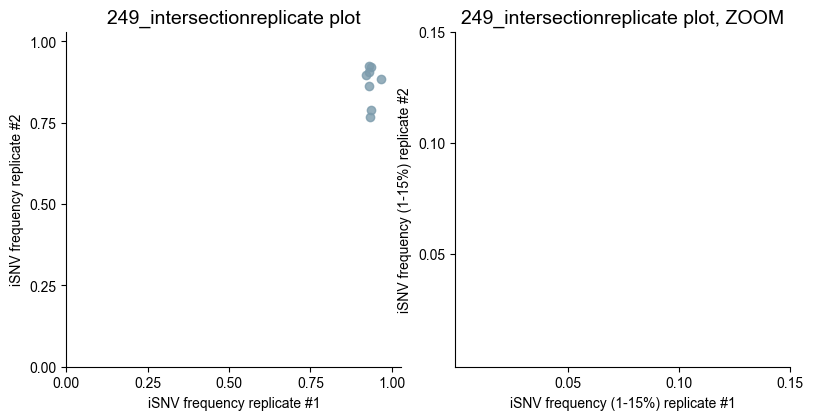

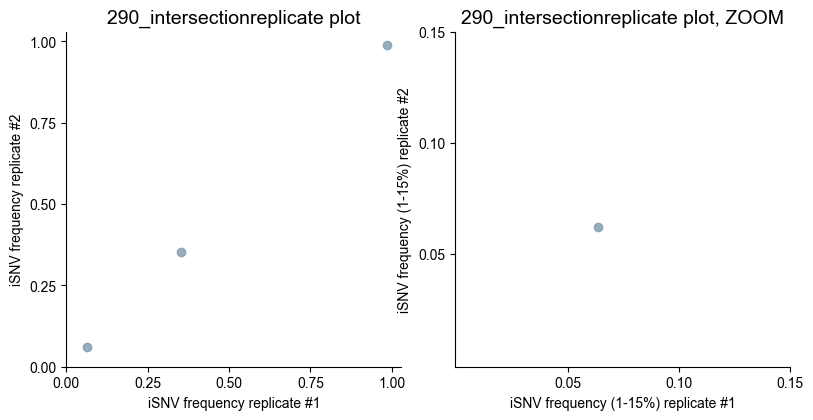

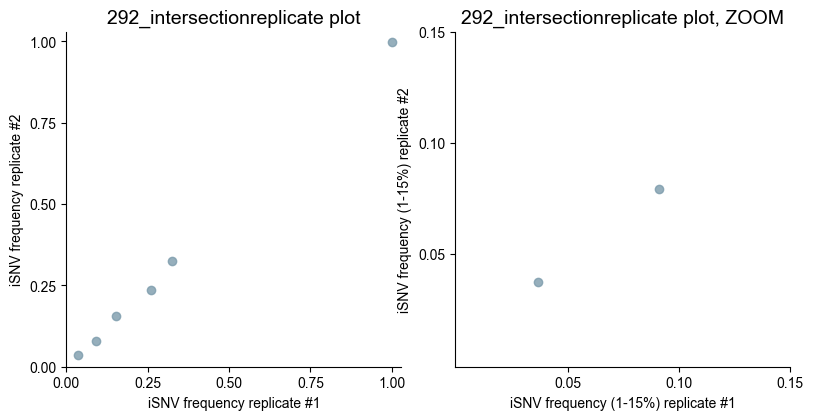

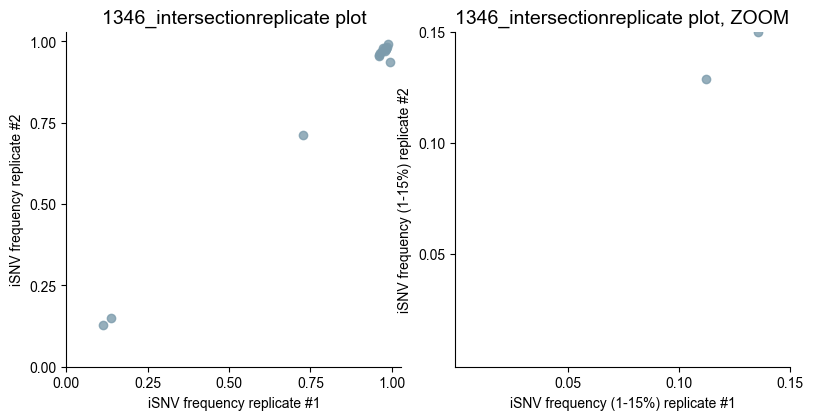

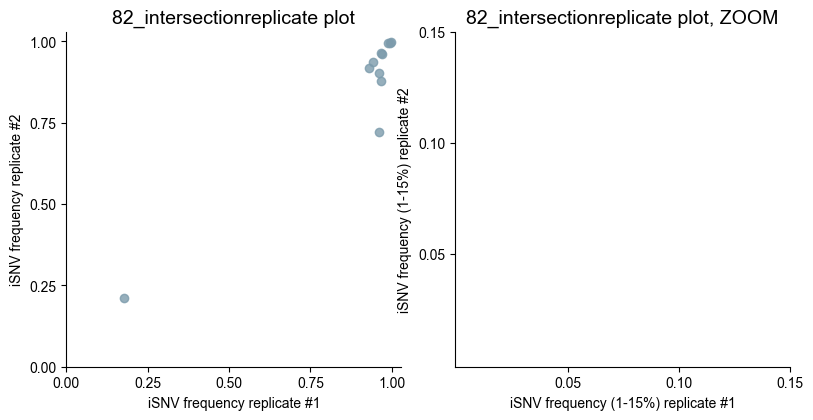

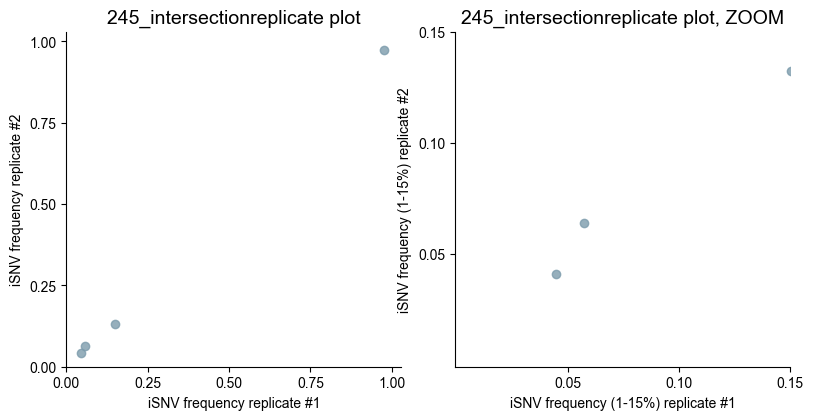

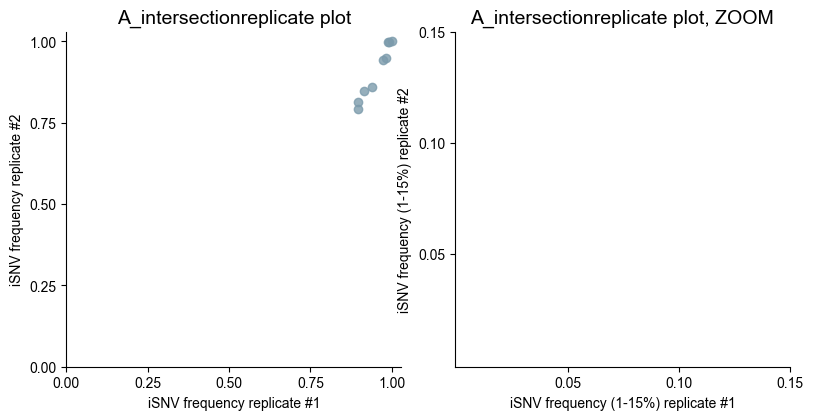

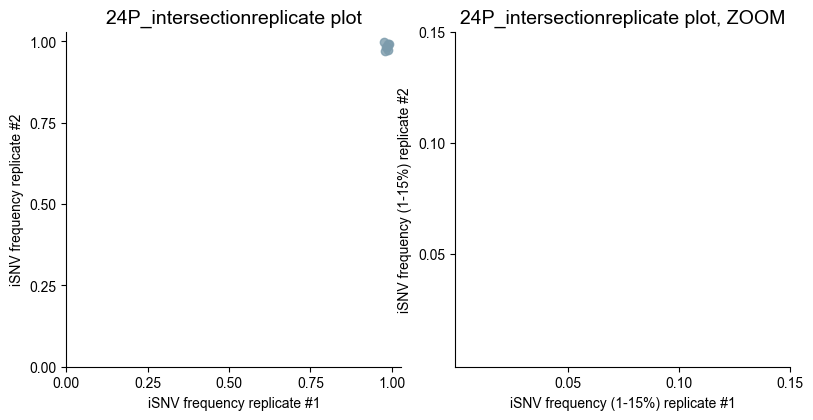

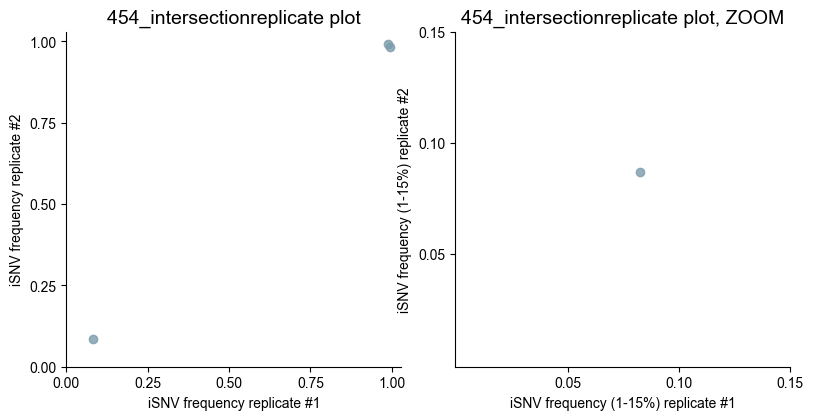

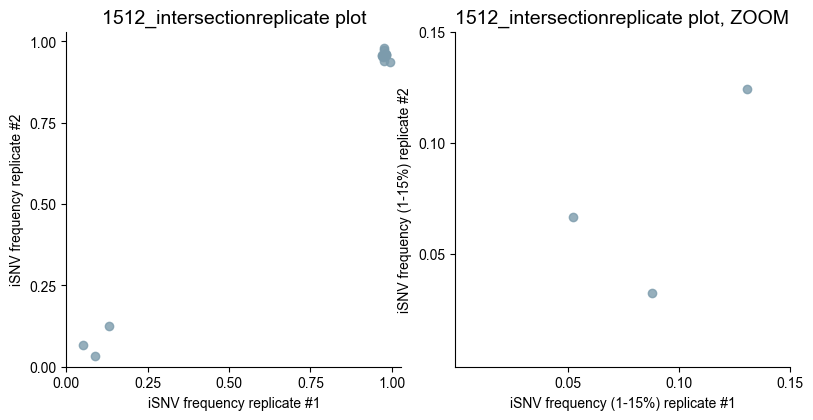

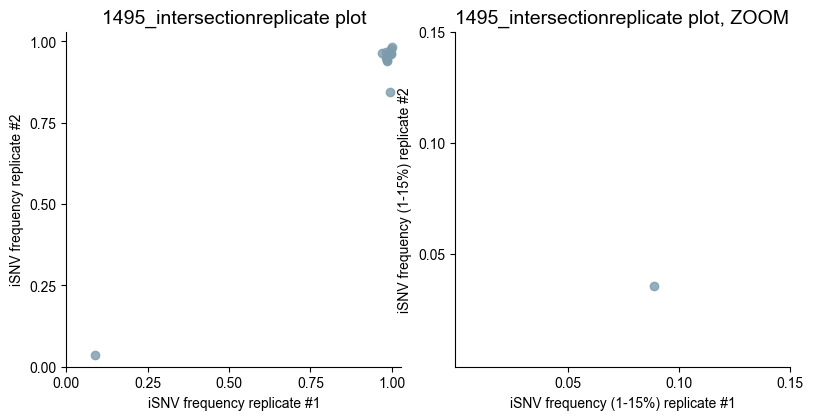

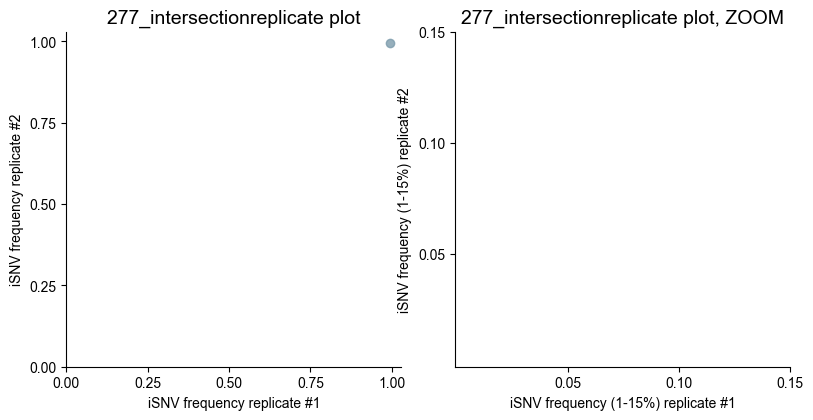

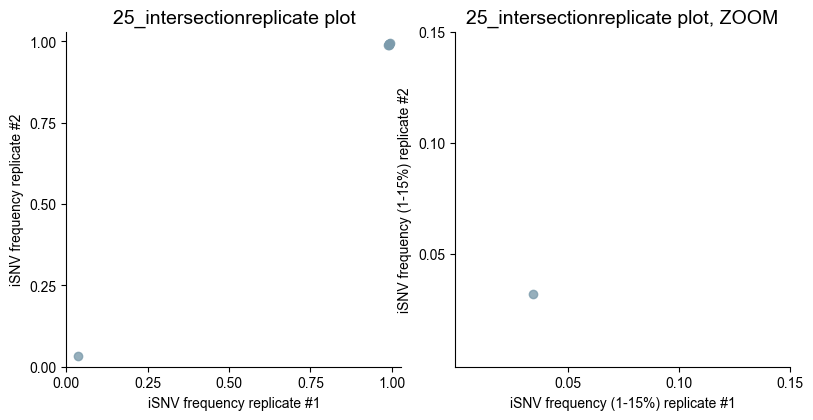

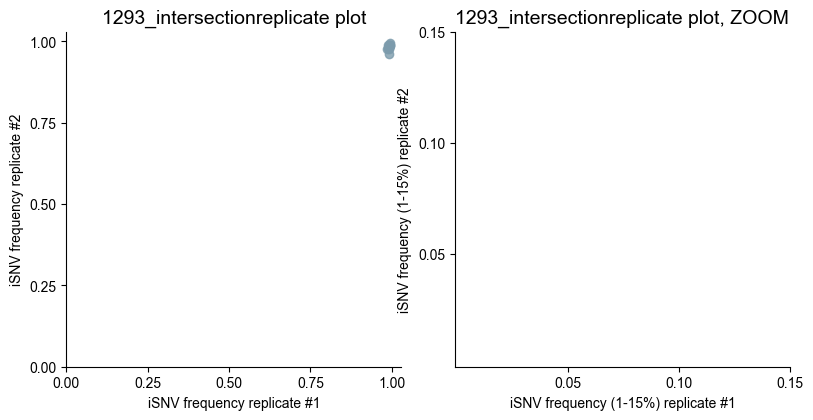

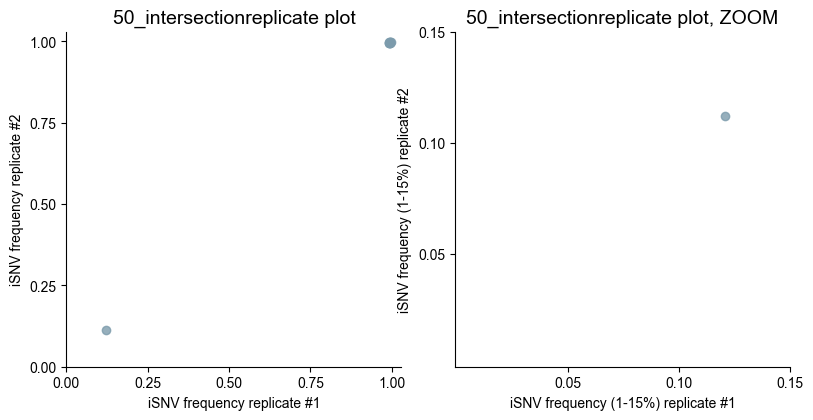

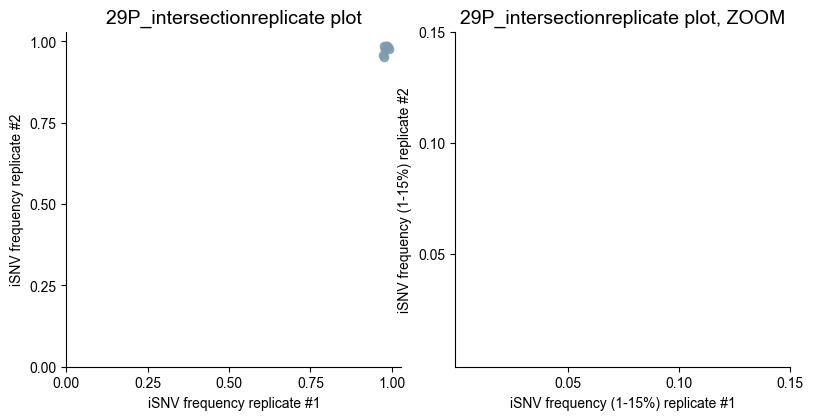

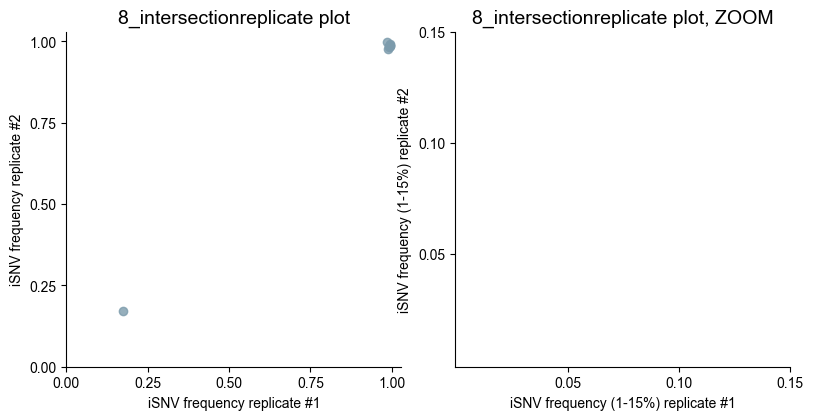

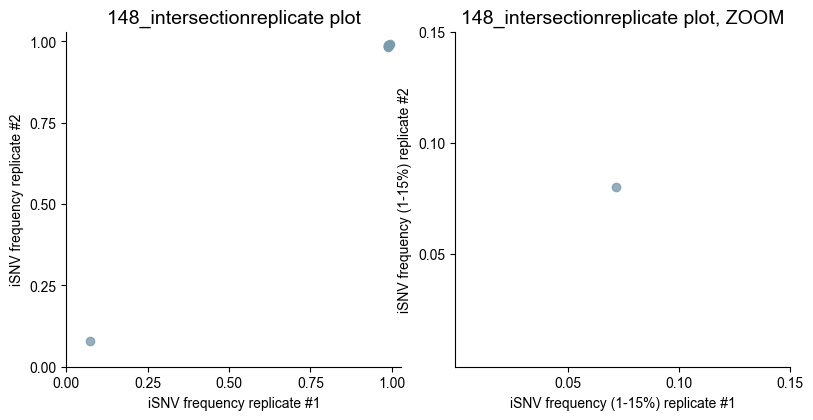

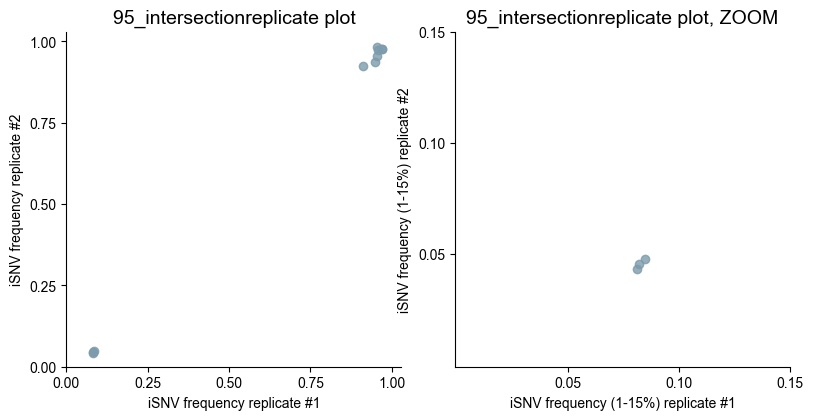

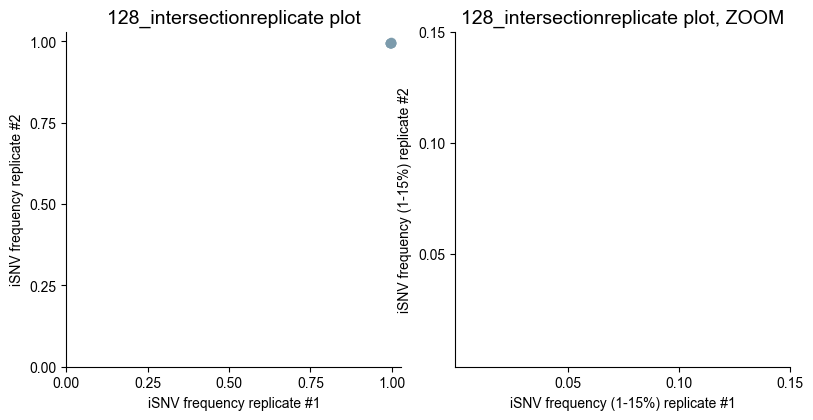

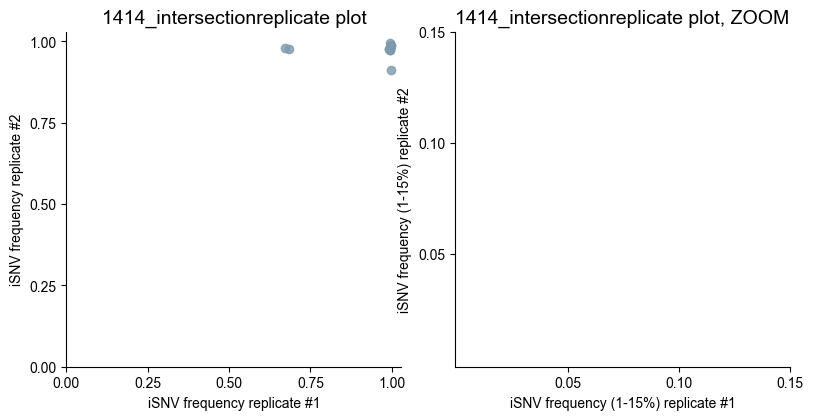

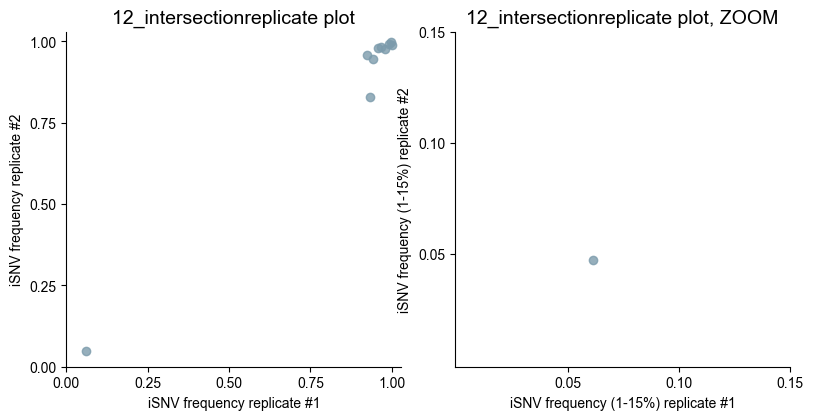

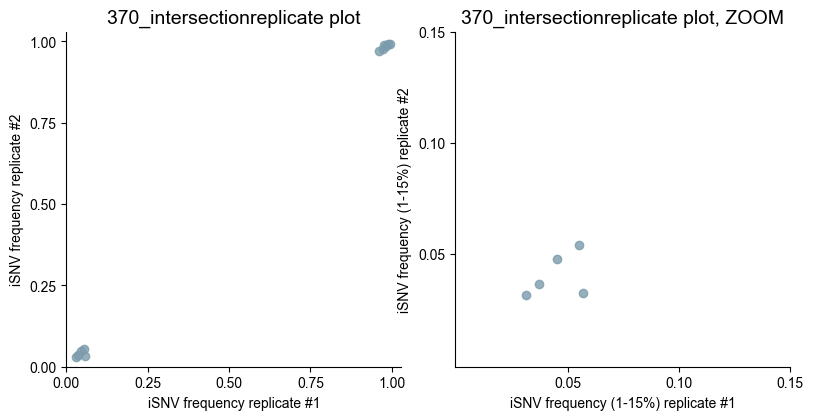

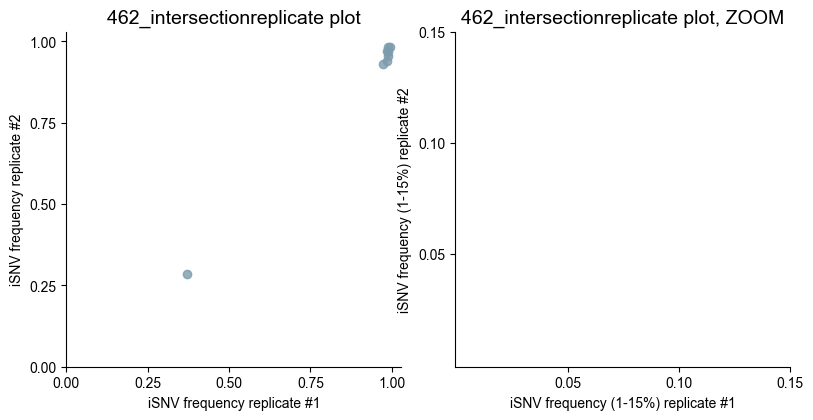

In [20]:
#list of intersection DFs
intersection_list = load_intersection_dataframes('../data/vcfs-intersection')

#plot rep1 against rep2
plot_intersection(intersection_list)

In [21]:
# concatenate all dataframes in the list_of_intersectoin_DFs into a single DF 

DF_3percent = pd.concat(list_of_intersection_DFs)

# DF_3percent

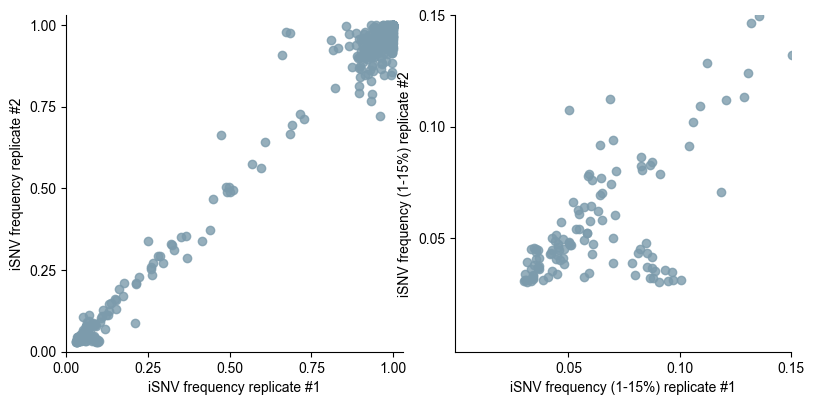

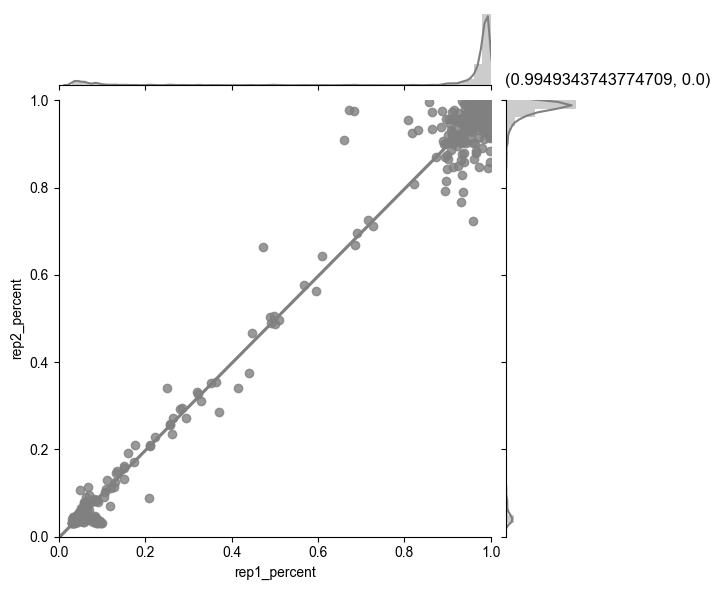

In [22]:
# plot intersections on a single plot to calculate linear correlation (I'd like to repeat this with multiple different frequency cut-offs)

plot_intersection_combined(intersection_list, DF_3percent)


#

## I am going to repeat the above function, but across a range of iSNV frequency cut-offs

### Then I will plot linear correlation value 


In [23]:
# load all text files in a directory into Pandas dataframes 
def load_dataframes(path):
    filelist = [os.path.splitext(file)[0] for file in os.listdir(path) if file.endswith('.vcf.recode.vcf')]
    list_of_DFs = []
    for file in filelist: 
        DF = path + '/' + file + '.vcf'
        file = pd.read_csv(DF, header=0, sep='\t', low_memory=False, skiprows=56)
        list_of_DFs.append(file)
    print(filelist)
    return(list_of_DFs)

# manipulate SNV dataframes to iSNV info + frequency only 
def clean_dataframes(path, list_of_DFs, freq_cutoff):
    for DF in list_of_DFs:
        sample = DF.columns[9]
        DF2 = DF.drop(['#CHROM', 'ID', 'QUAL', 'FILTER', 'FORMAT'], axis=1)
        DF1 = DF['INFO'].str.split('|', expand=True)
        DF3 = pd.concat([DF1, DF2], axis=1, join='inner')
        DF3[['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']] = DF3[sample].str.split(':', expand=True)
        DF = DF3[['POS', 'REF', 'ALT', 1, 3, 9, 10, 'B', 'D']]
        DF = DF.rename(columns={3: 'gene', 'D': 'FREQ', 1:'annotation', 'B': 'read_depth'})
        DF['gene_POS'] = DF[9].str.replace(r'[a-zA-Z.>]', '')
        DF[9].replace(regex=True, inplace=True, to_replace=r'c', value='')
        DF[9].replace(regex=True, inplace=True, to_replace=r'n', value='')
        DF[9].replace(regex=True, inplace=True, to_replace=r'\.', value='')
        DF[10].replace(regex=True, inplace=True, to_replace=r'p.', value='')
        DF['FREQ'].replace(regex=True, inplace=True, to_replace=r'%', value='')
        DF['annotation'].replace(regex=True, inplace=True, to_replace=r'_variant', value='')
        DF['annotation'].replace(regex=True, inplace=True, to_replace=r'_region', value='')
        DF = DF.rename(columns={9: 'nt_change', 10: 'aa_change'})
        DF['annotation'] = DF['annotation'].str.replace('stop_gained','stop')
        DF['annotation'] = DF['annotation'].str.replace('disruptive_inframe_deletion','frameshift')
        DF['annotation'] = DF['annotation'].str.replace('conservative_inframe_deletion','frameshift')
        DF['SNP'] = DF['gene'] + '_' + DF['nt_change'] + '_' + DF['aa_change'] + '_' + DF['annotation']
        DF['FREQ'] = pd.to_numeric(DF['FREQ']) #convert FREQ column from object type to int
        DF['read_depth'] = pd.to_numeric(DF['read_depth']) #convert FREQ column from object type to int
        DF['POS'] = pd.to_numeric(DF['POS']) #convert FREQ column from object type to int
        DF = DF[DF.read_depth >= 99] # drop any variants where read support is < 100 
        DF = DF[DF.FREQ >= freq_cutoff] # drop any variants that are ≤3% frequency (they may be erroneous
        DF = DF[DF.POS >= 54] # drop any variants that are called before nt position 55
        DF = DF[DF.POS <= 29837] # drop any variants that are called after nt position 29837
        DF = DF[~DF.SNP.str.contains("frameshift")]
        DF = DF[~DF.SNP.str.contains("del")]
        DF = DF[~DF.SNP.str.contains("disruptive")]
        DF.to_csv(path + '/' + sample + '-cleaned.csv', sep='\t')

#

In [24]:
# generate a list of dataframes, loaded from Illumina VCF files 
list_of_DFs = load_dataframes('../data/vcfs-recode')

print(len(list_of_DFs)) # this is the total number of samples we have, counting replicates

['356_rep2.vcf.recode', '356_rep1.vcf.recode', '366_rep2.vcf.recode', '18_rep1.vcf.recode', '175_rep1.vcf.recode', '182_rep1.vcf.recode', '17_rep1.vcf.recode', '17_rep2.vcf.recode', '195_rep2.vcf.recode', '18_rep2.vcf.recode', '175_rep2.vcf.recode', '195_rep1.vcf.recode', '182_rep2.vcf.recode', '196_rep1.vcf.recode', '255_rep2.vcf.recode', '24P_rep2.vcf.recode', '258_rep1.vcf.recode', '261_rep2.vcf.recode', '261_rep1.vcf.recode', '24P_rep1.vcf.recode', '25_rep1.vcf.recode', '258_rep2.vcf.recode', '252_rep2.vcf.recode', '255_rep1.vcf.recode', '25_rep2.vcf.recode', '252_rep1.vcf.recode', '249_rep2.vcf.recode', '249_rep1.vcf.recode', '268_rep1.vcf.recode', '60_rep1.vcf.recode', '57_rep2.vcf.recode', '55_rep1.vcf.recode', '5_rep1.vcf.recode', '57_rep1.vcf.recode', '55_rep2.vcf.recode', '61_rep2.vcf.recode', '56_rep1.vcf.recode', '64_rep1.vcf.recode', '56_rep2.vcf.recode', '61_rep1.vcf.recode', '64_rep2.vcf.recode', '5_rep2.vcf.recode', '60_rep2.vcf.recode', '884_rep1.vcf.recode', '81_rep1.

In [25]:
%%bash 

rm ../data/vcfs-variable-freq-cutoffs/cleaned/0.01/*
rm ../data/vcfs-variable-freq-cutoffs/cleaned/0.015/*
rm ../data/vcfs-variable-freq-cutoffs/cleaned/0.02/*
rm ../data/vcfs-variable-freq-cutoffs/cleaned/0.025/*
rm ../data/vcfs-variable-freq-cutoffs/cleaned/0.03/*
rm ../data/vcfs-variable-freq-cutoffs/cleaned/0.035/*
rm ../data/vcfs-variable-freq-cutoffs/cleaned/0.04/*
rm ../data/vcfs-variable-freq-cutoffs/cleaned/0.045/*
rm ../data/vcfs-variable-freq-cutoffs/cleaned/0.05/*

In [26]:
# clean up all of the dataframes and save to new CSV files 

clean_dataframes('../data/vcfs-variable-freq-cutoffs/cleaned/0.01', list_of_DFs, 0.01)
clean_dataframes('../data/vcfs-variable-freq-cutoffs/cleaned/0.015', list_of_DFs, 0.015)
clean_dataframes('../data/vcfs-variable-freq-cutoffs/cleaned/0.02', list_of_DFs, 0.02)
clean_dataframes('../data/vcfs-variable-freq-cutoffs/cleaned/0.025', list_of_DFs, 0.025)
clean_dataframes('../data/vcfs-variable-freq-cutoffs/cleaned/0.03', list_of_DFs, 0.03)
clean_dataframes('../data/vcfs-variable-freq-cutoffs/cleaned/0.035', list_of_DFs, 0.035)
clean_dataframes('../data/vcfs-variable-freq-cutoffs/cleaned/0.04', list_of_DFs, 0.04)
clean_dataframes('../data/vcfs-variable-freq-cutoffs/cleaned/0.045', list_of_DFs, 0.045)
clean_dataframes('../data/vcfs-variable-freq-cutoffs/cleaned/0.05', list_of_DFs, 0.05)

#

In [27]:
%%bash 

# remove all files (if there are any) in the `vcf-all` and `vcf-intersection` directories where consensus sequences are different across replicates
# after manual inspection of each of these bams, we were able to determine this was almost always due to low coverage in one or both replicates
# to be as conservative as possible with data we used in within- and between-host analyses, we dropped replicates for any samples where this was true

# with the above empty VCF filter (n=5), we are dropping 16 samples for quality issues at this stage 

rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.01/65_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.01/124_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.01/125_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.01/303_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.01/316_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.01/1061_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.01/1388_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.01/1103_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.01/1104_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.01/1147_rep1-cleaned.csv'
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.01/1282_rep1-cleaned.csv'

rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.01/65_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.01/124_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.01/125_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.01/303_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.01/316_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.01/1061_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.01/1388_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.01/1103_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.01/1104_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.01/1147_rep2-cleaned.csv'
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.01/1282_rep2-cleaned.csv'


#

In [28]:
%%bash 

# remove all files (if there are any) in the `vcf-all` and `vcf-intersection` directories where consensus sequences are different across replicates
# after manual inspection of each of these bams, we were able to determine this was almost always due to low coverage in one or both replicates
# to be as conservative as possible with data we used in within- and between-host analyses, we dropped replicates for any samples where this was true

# with the above empty VCF filter (n=5), we are dropping 16 samples for quality issues at this stage 

rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.015/65_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.015/124_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.015/125_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.015/303_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.015/316_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.015/1061_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.015/1388_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.015/1103_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.015/1104_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.015/1147_rep1-cleaned.csv'
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.015/1282_rep1-cleaned.csv'

rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.015/65_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.015/124_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.015/125_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.015/303_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.015/316_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.015/1061_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.015/1388_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.015/1103_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.015/1104_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.015/1147_rep2-cleaned.csv'
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.015/1282_rep2-cleaned.csv'


#

In [29]:
%%bash 

# remove all files (if there are any) in the `vcf-all` and `vcf-intersection` directories where consensus sequences are different across replicates
# after manual inspection of each of these bams, we were able to determine this was almost always due to low coverage in one or both replicates
# to be as conservative as possible with data we used in within- and between-host analyses, we dropped replicates for any samples where this was true

# with the above empty VCF filter (n=5), we are dropping 16 samples for quality issues at this stage 

rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.02/65_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.02/124_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.02/125_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.02/303_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.02/316_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.02/1061_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.02/1388_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.02/1103_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.02/1104_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.02/1147_rep1-cleaned.csv'
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.02/1282_rep1-cleaned.csv'

rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.02/65_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.02/124_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.02/125_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.02/303_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.02/316_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.02/1061_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.02/1388_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.02/1103_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.02/1104_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.02/1147_rep2-cleaned.csv'
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.02/1282_rep2-cleaned.csv'


#

In [30]:
%%bash 

# remove all files (if there are any) in the `vcf-all` and `vcf-intersection` directories where consensus sequences are different across replicates
# after manual inspection of each of these bams, we were able to determine this was almost always due to low coverage in one or both replicates
# to be as conservative as possible with data we used in within- and between-host analyses, we dropped replicates for any samples where this was true

# with the above empty VCF filter (n=5), we are dropping 16 samples for quality issues at this stage 

rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.025/65_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.025/124_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.025/125_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.025/303_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.025/316_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.025/1061_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.025/1388_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.025/1103_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.025/1104_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.025/1147_rep1-cleaned.csv'
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.025/1282_rep1-cleaned.csv'

rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.025/65_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.025/124_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.025/125_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.025/303_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.025/316_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.025/1061_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.025/1388_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.025/1103_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.025/1104_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.025/1147_rep2-cleaned.csv'
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.025/1282_rep2-cleaned.csv'


#

In [31]:
%%bash 

# remove all files (if there are any) in the `vcf-all` and `vcf-intersection` directories where consensus sequences are different across replicates
# after manual inspection of each of these bams, we were able to determine this was almost always due to low coverage in one or both replicates
# to be as conservative as possible with data we used in within- and between-host analyses, we dropped replicates for any samples where this was true

# with the above empty VCF filter (n=5), we are dropping 16 samples for quality issues at this stage 

rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.03/65_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.03/124_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.03/125_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.03/303_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.03/316_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.03/1061_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.03/1388_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.03/1103_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.03/1104_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.03/1147_rep1-cleaned.csv'
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.03/1282_rep1-cleaned.csv'

rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.03/65_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.03/124_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.03/125_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.03/303_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.03/316_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.03/1061_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.03/1388_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.03/1103_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.03/1104_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.03/1147_rep2-cleaned.csv'
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.03/1282_rep2-cleaned.csv'


#

In [32]:
%%bash 

# remove all files (if there are any) in the `vcf-all` and `vcf-intersection` directories where consensus sequences are different across replicates
# after manual inspection of each of these bams, we were able to determine this was almost always due to low coverage in one or both replicates
# to be as conservative as possible with data we used in within- and between-host analyses, we dropped replicates for any samples where this was true

# with the above empty VCF filter (n=5), we are dropping 16 samples for quality issues at this stage 

rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.035/65_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.035/124_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.035/125_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.035/303_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.035/316_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.035/1061_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.035/1388_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.035/1103_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.035/1104_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.035/1147_rep1-cleaned.csv'
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.035/1282_rep1-cleaned.csv'

rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.035/65_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.035/124_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.035/125_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.035/303_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.035/316_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.035/1061_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.035/1388_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.035/1103_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.035/1104_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.035/1147_rep2-cleaned.csv'
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.035/1282_rep2-cleaned.csv'


#

In [33]:
%%bash 

# remove all files (if there are any) in the `vcf-all` and `vcf-intersection` directories where consensus sequences are different across replicates
# after manual inspection of each of these bams, we were able to determine this was almost always due to low coverage in one or both replicates
# to be as conservative as possible with data we used in within- and between-host analyses, we dropped replicates for any samples where this was true

# with the above empty VCF filter (n=5), we are dropping 16 samples for quality issues at this stage 

rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.04/65_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.04/124_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.04/125_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.04/303_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.04/316_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.04/1061_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.04/1388_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.04/1103_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.04/1104_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.04/1147_rep1-cleaned.csv'
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.04/1282_rep1-cleaned.csv'

rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.04/65_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.04/124_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.04/125_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.04/303_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.04/316_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.04/1061_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.04/1388_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.04/1103_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.04/1104_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.04/1147_rep2-cleaned.csv'
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.04/1282_rep2-cleaned.csv'


#

In [34]:
%%bash 

# remove all files (if there are any) in the `vcf-all` and `vcf-intersection` directories where consensus sequences are different across replicates
# after manual inspection of each of these bams, we were able to determine this was almost always due to low coverage in one or both replicates
# to be as conservative as possible with data we used in within- and between-host analyses, we dropped replicates for any samples where this was true

# with the above empty VCF filter (n=5), we are dropping 16 samples for quality issues at this stage 

rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.045/65_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.045/124_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.045/125_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.045/303_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.045/316_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.045/1061_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.045/1388_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.045/1103_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.045/1104_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.045/1147_rep1-cleaned.csv'
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.045/1282_rep1-cleaned.csv'

rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.045/65_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.045/124_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.045/125_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.045/303_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.045/316_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.045/1061_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.045/1388_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.045/1103_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.045/1104_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.045/1147_rep2-cleaned.csv'
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.045/1282_rep2-cleaned.csv'


#

In [35]:
%%bash 

# remove all files (if there are any) in the `vcf-all` and `vcf-intersection` directories where consensus sequences are different across replicates
# after manual inspection of each of these bams, we were able to determine this was almost always due to low coverage in one or both replicates
# to be as conservative as possible with data we used in within- and between-host analyses, we dropped replicates for any samples where this was true

# with the above empty VCF filter (n=5), we are dropping 16 samples for quality issues at this stage 

rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.05/65_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.05/124_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.05/125_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.05/303_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.05/316_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.05/1061_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.05/1388_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.05/1103_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.05/1104_rep1-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.05/1147_rep1-cleaned.csv'
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.05/1282_rep1-cleaned.csv'

rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.05/65_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.05/124_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.05/125_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.05/303_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.05/316_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.05/1061_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.05/1388_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.05/1103_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.05/1104_rep2-cleaned.csv' 
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.05/1147_rep2-cleaned.csv'
rm '../data/vcfs-variable-freq-cutoffs/cleaned/0.05/1282_rep2-cleaned.csv'


#

In [36]:
def find_intersection(path, df_list, freq_cutoff):
    # create list of unique dataframe identifiers – this enables easy pairing of csvs
    value_list=[]
    value_set=[]
    list_of_DF_names_all = []
    list_of_DF_names_intersection_only = []
    for item in df_list:
        if "rep1" in item:
            value = item.replace("rep1-cleaned.csv","")
        if "rep2" in item:
            value = item.replace("rep2-cleaned.csv","")
            value_list.append(value)
#             print(value_list)
        value_set=set(value_list)   
#             print(value_list)
    merged_len = []
    merged_len_intersection = []
    for item in value_set:
        # create dataframes from csv files
        rep1_path = path + item + 'rep1-cleaned.csv'
        rep1_df = pd.read_csv(rep1_path, sep='\t')
        rep2_path = path + item + 'rep2-cleaned.csv'
        rep2_df = pd.read_csv(rep2_path, sep='\t')
        # clean up column names
        rep1_df = rep1_df.rename(columns={'FREQ': '%-rep1'})
        rep2_df = rep2_df.rename(columns={'FREQ': '%-rep2'})
        A1_1m = rep1_df[['SNP', '%-rep1', 'POS']]
        B1_1m = rep2_df[['SNP', '%-rep2', 'POS']]
        df1_1 = pd.merge(A1_1m, B1_1m, on='SNP', how='outer')
        l = len(df1_1)
        df1_1['POS_x'] = df1_1['POS_x'].fillna(df1_1['POS_y'])
        df1_1 = df1_1[['SNP', 'POS_x', '%-rep1', '%-rep2']]
        df1_1 = df1_1.sort_values('POS_x', ascending=True)
        df1_1['FREQ'] = df1_1[['%-rep1', '%-rep2']].mean(axis=1)
        df1_1 = df1_1.rename(columns={'%-rep1': 'rep1_percent', '%-rep2': 'rep2_percent'})
        df1_1.loc[df1_1.FREQ >= 0.97, 'FREQ'] = 1.0 # any SNVs average >0.97 FREQ are likely fixed so I'll rewrite anything >0.97 to 1.0
        df1_1 = df1_1.rename(columns={'FREQ': '%'})
        df1_1_intersection = df1_1.dropna()
        df1_1 = df1_1.fillna(0)
#         print(df1_1_intersection)
        list_of_DF_names_all.append(df1_1)
        list_of_DF_names_intersection_only.append(df1_1_intersection)
        m = len(df1_1_intersection)
        merged_len.append(l)
        merged_len_intersection.append(m)
    print(sum(merged_len))
    print(sum(merged_len_intersection))
    merged_DFs_all = pd.concat(list_of_DF_names_all)
    merged_DFs_all.to_csv('../data/vcfs-variable-freq-cutoffs/merged-all/'+ freq_cutoff + '/' + 'merged-intersection.csv', sep='\t')
    merged_DFs_intersection_only = pd.concat(list_of_DF_names_intersection_only)
    merged_DFs_intersection_only.to_csv('../data/vcfs-variable-freq-cutoffs/merged-intersection/'+ freq_cutoff + '/' + 'merged-intersection-all.csv', sep='\t')
    return(merged_DFs_all)
    #

In [37]:
%%bash 

rm ../data/vcfs-variable-freq-cutoffs/merged-all/0.01/*
rm ../data/vcfs-variable-freq-cutoffs/merged-all/0.015/*
rm ../data/vcfs-variable-freq-cutoffs/merged-all/0.02/*
rm ../data/vcfs-variable-freq-cutoffs/merged-all/0.025/*
rm ../data/vcfs-variable-freq-cutoffs/merged-all/0.03/*
rm ../data/vcfs-variable-freq-cutoffs/merged-all/0.035/*
rm ../data/vcfs-variable-freq-cutoffs/merged-all/0.04/*
rm ../data/vcfs-variable-freq-cutoffs/merged-all/0.045/*
rm ../data/vcfs-variable-freq-cutoffs/merged-all/0.05/*

In [38]:
%%bash 

rm ../data/vcfs-variable-freq-cutoffs/merged-intersection/0.01/*
rm ../data/vcfs-variable-freq-cutoffs/merged-intersection/0.015/*
rm ../data/vcfs-variable-freq-cutoffs/merged-intersection/0.02/*
rm ../data/vcfs-variable-freq-cutoffs/merged-intersection/0.025/*
rm ../data/vcfs-variable-freq-cutoffs/merged-intersection/0.03/*
rm ../data/vcfs-variable-freq-cutoffs/merged-intersection/0.035/*
rm ../data/vcfs-variable-freq-cutoffs/merged-intersection/0.04/*
rm ../data/vcfs-variable-freq-cutoffs/merged-intersection/0.045/*
rm ../data/vcfs-variable-freq-cutoffs/merged-intersection/0.05/*

In [39]:
# make a list of the cleaned CSV files 

directory = '../data/vcfs-variable-freq-cutoffs/cleaned/0.01/'
files_dir =  os.listdir(directory)
newlist = []
for names in files_dir:
    if names.endswith(".csv"):
        newlist.append(names)
# print(newlist)

c = find_intersection('../data/vcfs-variable-freq-cutoffs/cleaned/0.01/', newlist, '0.01')

8371
1862


In [40]:
# make a list of the cleaned CSV files 

directory = '../data/vcfs-variable-freq-cutoffs/cleaned/0.015/'
files_dir =  os.listdir(directory)
newlist = []
for names in files_dir:
    if names.endswith(".csv"):
        newlist.append(names)
# print(newlist)

d = find_intersection('../data/vcfs-variable-freq-cutoffs/cleaned/0.015/', newlist, '0.015')

5123
1463


In [41]:
# make a list of the cleaned CSV files 

directory = '../data/vcfs-variable-freq-cutoffs/cleaned/0.02/'
files_dir =  os.listdir(directory)
newlist = []
for names in files_dir:
    if names.endswith(".csv"):
        newlist.append(names)
# print(newlist)

e = find_intersection('../data/vcfs-variable-freq-cutoffs/cleaned/0.02/', newlist, '0.02')

3664
1307


In [42]:
# make a list of the cleaned CSV files 

directory = '../data/vcfs-variable-freq-cutoffs/cleaned/0.025/'
files_dir =  os.listdir(directory)
newlist = []
for names in files_dir:
    if names.endswith(".csv"):
        newlist.append(names)
# print(newlist)

f = find_intersection('../data/vcfs-variable-freq-cutoffs/cleaned/0.025/', newlist, '0.025')

2876
1224


In [43]:
# make a list of the cleaned CSV files 

directory = '../data/vcfs-variable-freq-cutoffs/cleaned/0.03/'
files_dir =  os.listdir(directory)
newlist = []
for names in files_dir:
    if names.endswith(".csv"):
        newlist.append(names)
# print(newlist)

g = find_intersection('../data/vcfs-variable-freq-cutoffs/cleaned/0.03/', newlist, '0.03')

2371
1183


In [44]:
# make a list of the cleaned CSV files 

directory = '../data/vcfs-variable-freq-cutoffs/cleaned/0.035/'
files_dir =  os.listdir(directory)
newlist = []
for names in files_dir:
    if names.endswith(".csv"):
        newlist.append(names)
# print(newlist)

h = find_intersection('../data/vcfs-variable-freq-cutoffs/cleaned/0.035/', newlist, '0.035')

2059
1156


In [45]:
# make a list of the cleaned CSV files 

directory = '../data/vcfs-variable-freq-cutoffs/cleaned/0.04/'
files_dir =  os.listdir(directory)
newlist = []
for names in files_dir:
    if names.endswith(".csv"):
        newlist.append(names)
# print(newlist)

i = find_intersection('../data/vcfs-variable-freq-cutoffs/cleaned/0.04/', newlist, '0.04')

1871
1138


In [46]:
# make a list of the cleaned CSV files 

directory = '../data/vcfs-variable-freq-cutoffs/cleaned/0.045/'
files_dir =  os.listdir(directory)
newlist = []
for names in files_dir:
    if names.endswith(".csv"):
        newlist.append(names)
# print(newlist)

j = find_intersection('../data/vcfs-variable-freq-cutoffs/cleaned/0.045/', newlist, '0.045')

1719
1123


In [47]:
# make a list of the cleaned CSV files 

directory = '../data/vcfs-variable-freq-cutoffs/cleaned/0.05/'
files_dir =  os.listdir(directory)
newlist = []
for names in files_dir:
    if names.endswith(".csv"):
        newlist.append(names)
# print(newlist)

k = find_intersection('../data/vcfs-variable-freq-cutoffs/cleaned/0.05/', newlist, '0.05')

1614
1110


In [48]:
def plot_intersection_combined_all(concat_dataframe, freq_cutoff):
    # global settings 
    fig1 = plt.figure(figsize=(8,8), facecolor='w')
    plt.style.use('default')
    mpl.rc('font', family='Arial')
    gs = gridspec.GridSpec(2,10)
    
    r2 = stats.pearsonr(concat_dataframe['rep1_percent'], concat_dataframe['rep2_percent'])
    p = sns.jointplot(data=concat_dataframe, x='rep1_percent', y='rep2_percent', kind="reg", ylim=(0,1), xlim=(0,1), color='grey')
    p.fig.text(0.85, 0.85, r2, fontsize=12)
    
    # save this plot to the figures folder 
    p.savefig('../figures/intersection-by-frequency/' + freq_cutoff + '-all.pdf', bbox_inches='tight', dpi=300)

#

<Figure size 800x800 with 0 Axes>

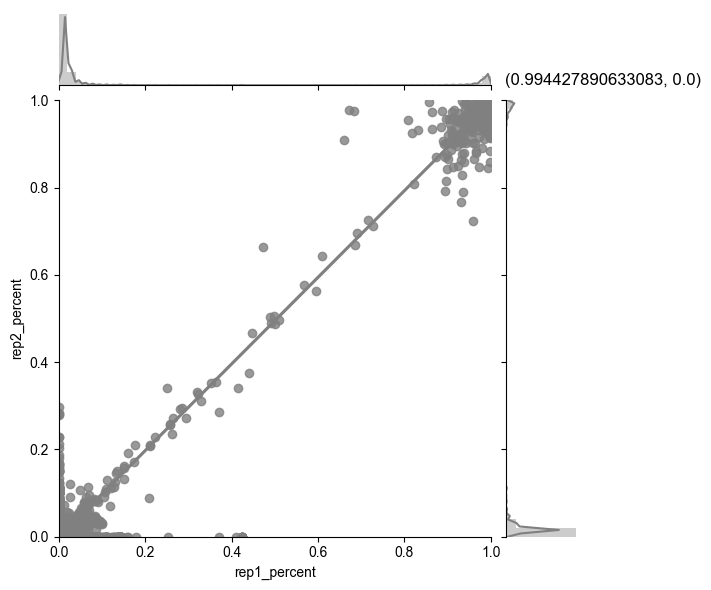

<Figure size 800x800 with 0 Axes>

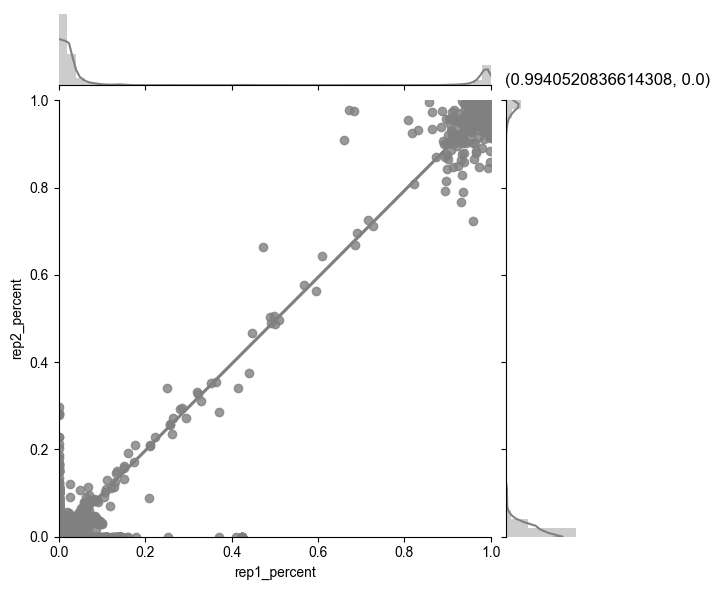

<Figure size 800x800 with 0 Axes>

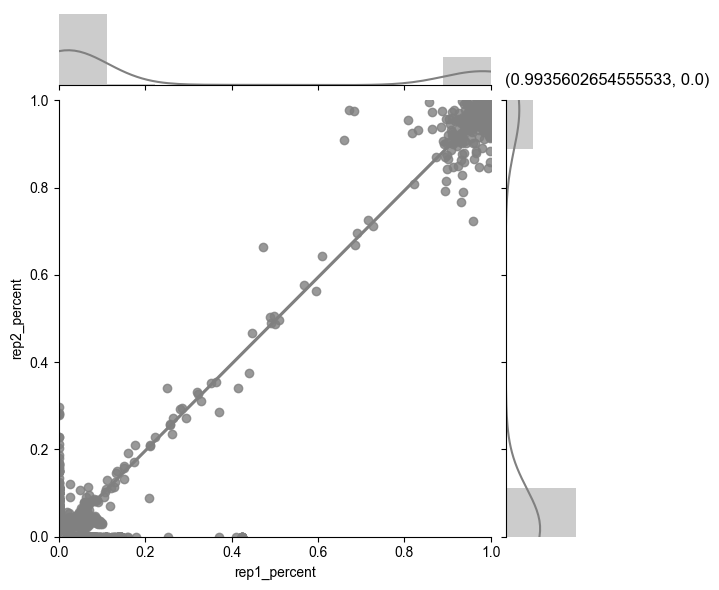

<Figure size 800x800 with 0 Axes>

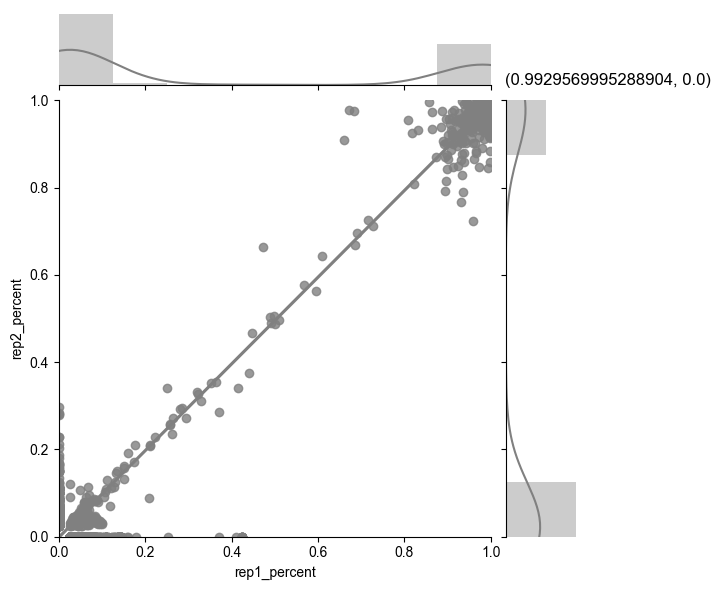

<Figure size 800x800 with 0 Axes>

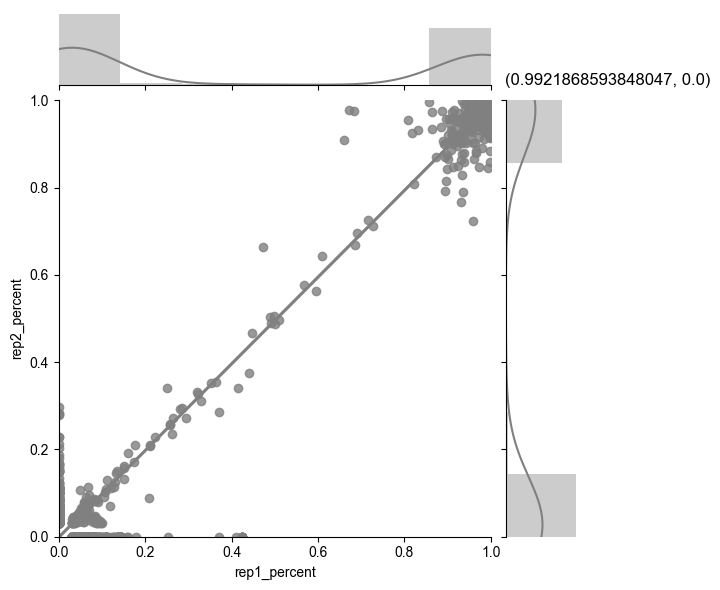

<Figure size 800x800 with 0 Axes>

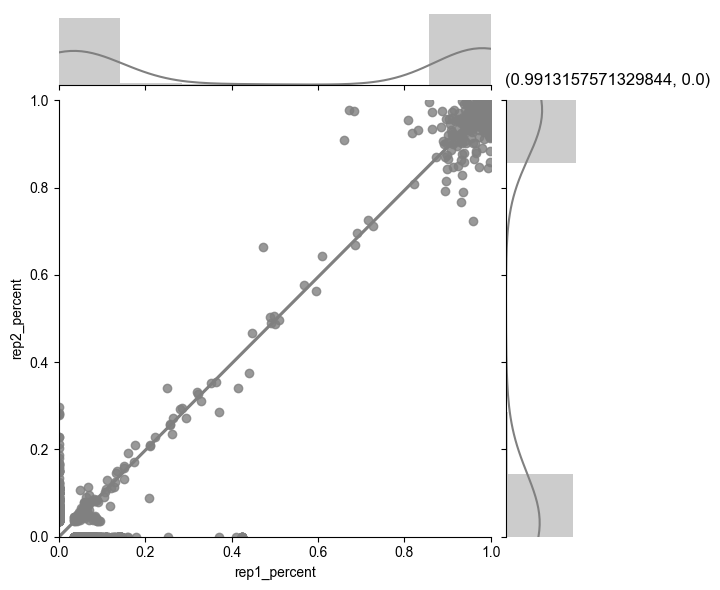

<Figure size 800x800 with 0 Axes>

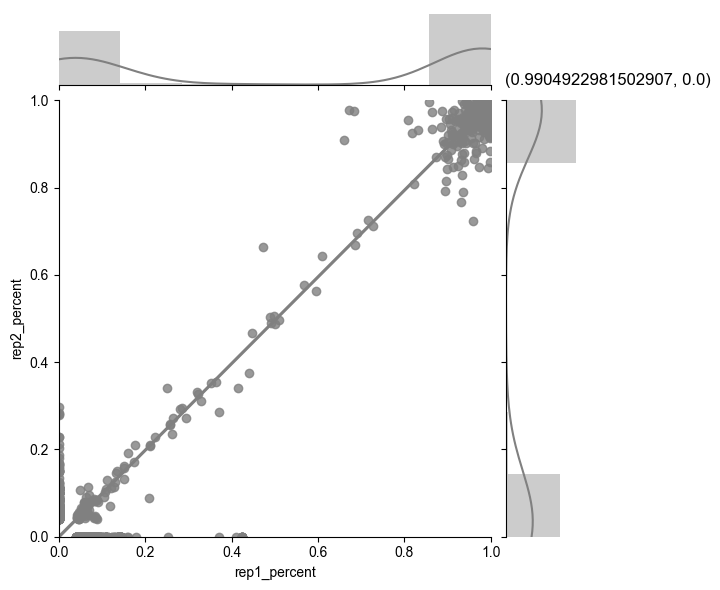

<Figure size 800x800 with 0 Axes>

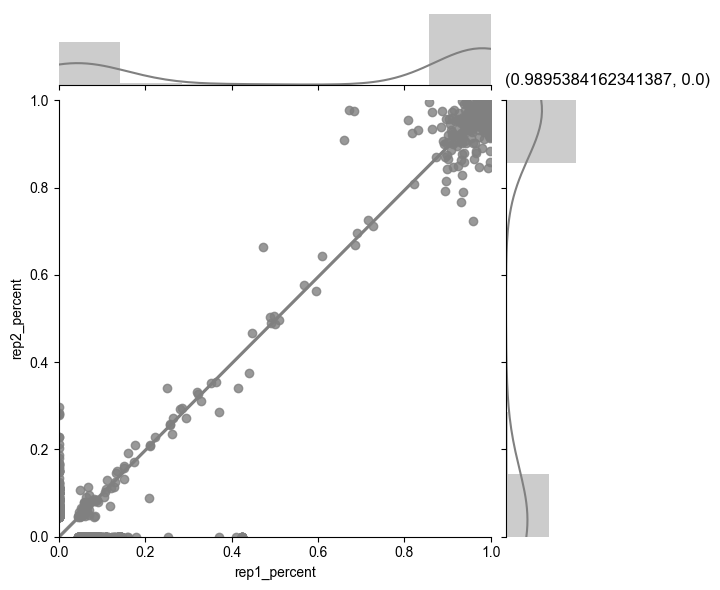

<Figure size 800x800 with 0 Axes>

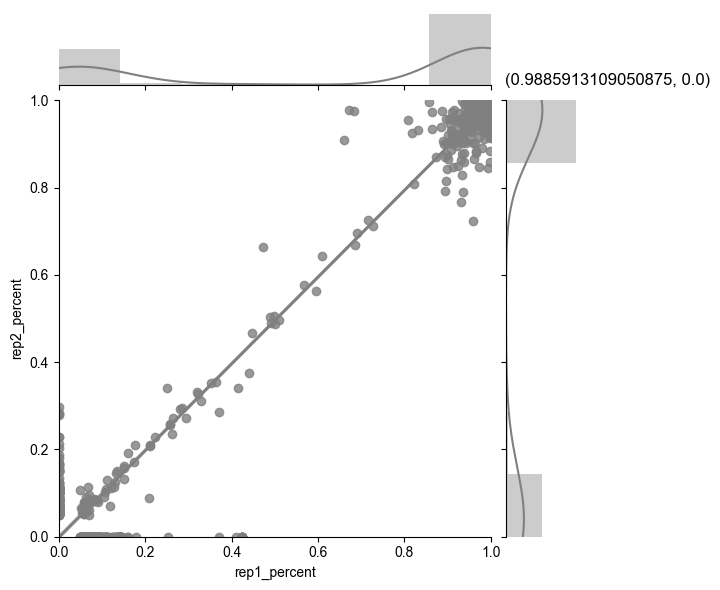

In [49]:
# plot intersection with all variants, not just variants found in both replicates 

plot_intersection_combined_all(c, '0.01')
plot_intersection_combined_all(d, '0.015')
plot_intersection_combined_all(e, '0.02')
plot_intersection_combined_all(f, '0.025')
plot_intersection_combined_all(g, '0.03')
plot_intersection_combined_all(h, '0.035')
plot_intersection_combined_all(i, '0.04')
plot_intersection_combined_all(j, '0.045')
plot_intersection_combined_all(k, '0.05')


##

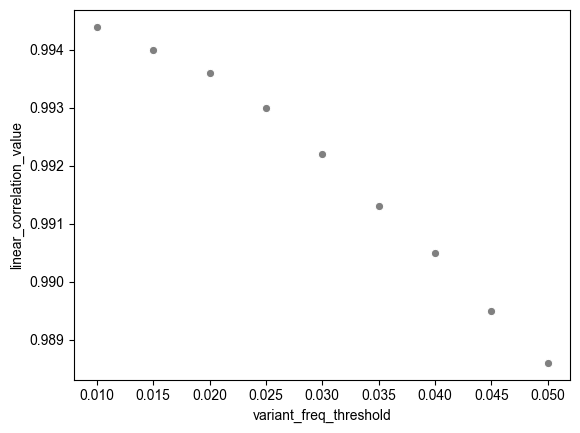

In [50]:
data = [[0.01, 0.9944], [0.015, 0.9940], [0.02, 0.9936], [0.025, 0.9930], [0.03, 0.9922], [0.035, 0.9913], [0.04, 0.9905], [0.045, 0.9895], [0.05, 0.9886]]
intersection_by_freq = pd.DataFrame(data, columns = ['variant_freq_threshold', 'linear_correlation_value'])

intersection_by_freq

c = sns.scatterplot(x=intersection_by_freq['variant_freq_threshold'], y=intersection_by_freq['linear_correlation_value'], color='grey')
plt.savefig('../figures/linear-correlation-vs-freq-threshold.pdf', bbox_inches='tight', dpi=300)


##

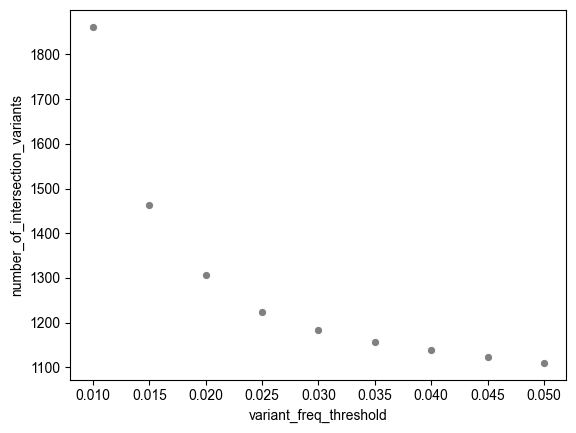

In [51]:
data = [[0.01, 1862], [0.015, 1463], [0.02, 1307], [0.025, 1224], [0.03, 1183], [0.035, 1156], [0.04, 1138], [0.045, 1123], [0.05, 1110]]
intersection_by_freq = pd.DataFrame(data, columns = ['variant_freq_threshold', 'number_of_intersection_variants'])

intersection_by_freq

c = sns.scatterplot(x=intersection_by_freq['variant_freq_threshold'], y=intersection_by_freq['number_of_intersection_variants'], color='grey')
plt.savefig('../figures/intersection-variants-vs-freq-threshold.pdf', bbox_inches='tight', dpi=300)


##

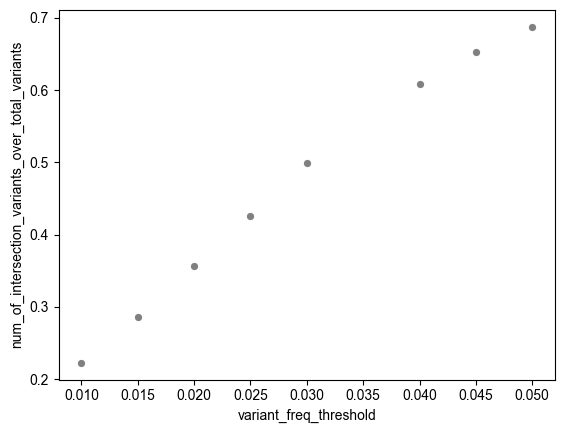

In [52]:
data = [[0.01, 1862/8371], [0.015, 1463/5123], [0.02, 1307/3664], [0.025, 1224/2876], [0.03, 1183/2371], [1156/2059], [0.04, 1138/1871], [0.045, 1123/1719], [0.05, 1110/1614]]
intersection_by_freq = pd.DataFrame(data, columns = ['variant_freq_threshold', 'num_of_intersection_variants_over_total_variants'])

intersection_by_freq

c = sns.scatterplot(x=intersection_by_freq['variant_freq_threshold'], y=intersection_by_freq['num_of_intersection_variants_over_total_variants'], color='grey')
plt.savefig('../figures/intersection-variants-over-total-variants-vs-freq-threshold.pdf', bbox_inches='tight', dpi=300)


##